---

# 스프린트미션7 4팀_김명환

1. 미션 소개
- 이번 미션에서는 SSD 모델을 활용하여 개와 고양이의 얼굴(Face) 영역을 감지하는 Object Detection 작업을 수행해 봅시다.

2. 데이터 소개
- 데이터 링크(The Oxford-IIIT Pet Dataset)
- annotations(xml): 각 이미지 파일에 대한 annotation
- images: 이미지 파일(37종의 개와 고양이)

3. 제출 안내
- 다음 내용을 포함한 Colab Notebook 파일을 제출해 주세요. 파일 이름은 각각 07_{팀명}_{성함}.ipynb로 해주세요.

4. 분석 과정과 결과:
- 데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
- Bounding Box에 대한 정보를 활용하여 SSD 모델을 활용한 Object Detection을 수행해 보세요.
- 마크다운을 활용한 설명
- 코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
- 코드와 실행 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.

5. 모델 성능 평가 및 제출
- 평가 지표(mAP, IOU 등)를 활용해 모델 성능을 분석하고 비교해 보세요.
- 제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트해 보세요.
- 모델별 성능 평가 결과를 포함한 노트북 파일을 제출하세요.

---
---

# SSD를 활용한 Pet Face Detection 미션 보고서

## 1. 프로젝트 개요

### 1.1. 미션 목표
Oxford-IIIT Pet Dataset을 활용하여 개와 고양이의 얼굴 영역을 감지하는 Object Detection 모델을 구현합니다. Single Shot MultiBox Detector (SSD) 아키텍처를 기반으로 두 가지 백본 네트워크를 비교 분석하였습니다.

### 1.2. 주요 과제
- **데이터셋**: Oxford-IIIT Pet Dataset (37종의 개와 고양이)
- **모델**: SSD300 아키텍처 (VGG16 vs ResNet34 백본)
- **클래스**: 3개 클래스 (background, cat, dog)
- **평가 지표**: mAP (Mean Average Precision), IoU (Intersection over Union)


<img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/1_2_mermaid_%EC%A3%BC%EC%9A%94%EA%B3%BC%EC%A0%9C.png" width="640px"/>

--

### 1.3 OXFORD-IIIT PET Dataset (옥스포드-IIIT 애완동물 데이터셋)
*Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar*

우리는 각 클래스별로 약 200개의 이미지로 구성된 **37개 범주의 애완동물 데이터셋**을 만들었습니다. 이 이미지들은 크기, 자세, 조명에서 큰 변화를 보입니다. 모든 이미지에는 품종, 머리 ROI(관심 영역), 그리고 픽셀 단위의 트라이맵(trimap) 분할에 대한 진실값(ground truth) 주석이 포함되어 있습니다.

---

### 1.4 **내용물**

* **`trimaps/`**
    * 데이터셋의 모든 이미지에 대한 트라이맵 주석
    * **픽셀 주석**: 1: 전경(Foreground), 2: 배경(Background), 3: 분류되지 않음(Not classified)
* **`xmls/`**
    * PASCAL VOC 형식의 머리 경계 상자(bounding box) 주석
* **`list.txt`**
    * 데이터셋의 모든 이미지를 결합한 목록 파일
    * **형식**: `Image CLASS-ID SPECIES BREED ID`
        * **ID**: 1~37번 클래스 ID
        * **SPECIES(종)**: 1: 고양이, 2: 개
        * **BREED ID(품종 ID)**: 고양이는 1~25, 개는 1~12
    * 첫 글자가 **대문자**인 이미지는 고양이, **소문자**인 이미지는 개입니다.
* **`trainval.txt`** / **`test.txt`**
    * 논문에서 사용된 분할(split)을 설명하는 파일입니다. 하지만 무작위 분할을 시도해 보는 것을 권장합니다.

- 이미지 셈플

| Train | Test |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/train0.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/test0.png" width="180px"/> |

- 종 분포

| Train | Test |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/%EC%9B%90%EB%B3%B8_Train_%EA%B3%A0%EC%96%91%EC%9D%B4_%EA%B0%9C_%EC%A2%85%EB%B6%84%ED%8F%AC.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/%EC%9B%90%EB%B3%B8_Test_%EA%B3%A0%EC%96%91%EC%9D%B4_%EA%B0%9C_%EC%A2%85%EB%B6%84%ED%8F%AC.png" width="320px"/> |

- 품종 분포

| Train | Test |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/%EC%9B%90%EB%B3%B8_Train_%EA%B3%A0%EC%96%91%EC%9D%B4_%ED%92%88%EC%A2%85_%EB%B6%84%ED%8F%AC.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/%EC%9B%90%EB%B3%B8_Train_%EA%B0%95%EC%95%84%EC%A7%80_%ED%92%88%EC%A2%85_%EB%B6%84%ED%8F%AC.png" width="320px"/> |

---

### 1.5 **지원 및 참고 문헌**

* **지원**: 문의사항은 Omkar Parkhi (omkar@robots.ox.ac.uk)에게 연락하세요.
* **참고 문헌**:
    * [1] O. M. Parkhi, A. Vedaldi, A. Zisserman, C. V. Jawahar, "Cats and Dogs,"*IEEE Conference on Computer Vision and Pattern Recognition*, 2012

---

## 2. SSD 모델 아키텍처 분석

### 2.1. SSD 기본 원리

SSD (Single Shot MultiBox Detector)는 한 번의 forward pass로 객체의 위치와 클래스를 동시에 예측하는 원샷 디텍션(one-shot detection) 모델입니다. YOLO와 달리 다양한 스케일의 특징맵을 활용하여 크기가 다른 객체들을 효과적으로 감지할 수 있습니다.

#### 핵심 특징:
- **속도**: 실시간 처리 가능한 빠른 속도
- **정확도**: 다중 스케일 특징맵으로 높은 정확도
- **유연성**: 다양한 백본 네트워크 활용 가능

### 2.2. Multi-Scale Feature Maps

SSD의 핵심은 서로 다른 해상도의 특징맵에서 객체를 감지하는 것입니다. 각 특징맵은 서로 다른 크기의 객체를 담당합니다.

$$\text{Feature Map Size} = \frac{\text{Input Size}}{\text{Stride}}$$

<img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/2_2_mermaid_Multi-Scale_Feature_Maps.png" width="640px"/>

### 2.3. Default Box Generation

각 특징맵의 픽셀 위치에서 다양한 크기와 비율의 앵커 박스(default box)를 생성합니다.

$$\text{Box Width} = s_k \sqrt{a_r}$$
$$\text{Box Height} = \frac{s_k}{\sqrt{a_r}}$$

여기서 $s_k$는 스케일, $a_r$은 어스펙트 레이셔(aspect ratio)입니다.

---

## 3. 모델 구현 및 비교

### 3.1. SSD300_VGG16 (전이학습 방식)

#### 3.1.1. 구현 전략
사전훈련된 COCO 데이터셋의 SSD300_VGG16 모델을 Pet Detection 태스크에 맞게 전이학습합니다.

**핵심 수정사항:**
- **Classification Head 교체**: 91개 클래스 → 3개 클래스
- **Backbone 유지**: VGG16 특징추출기 그대로 활용
- **Regression Head 유지**: 바운딩 박스 예측 부분 재사용

#### 3.1.2. 아키텍처 분석

**백본 구조 (VGG16 기반):**
```
features: Conv2d layers (0-22) - 기본 VGG16 구조
extra: ModuleList (0-4) - 추가 특징맵 생성
├── MaxPool + Conv layers
├── Dilated Convolution (dilation=6)
└── Progressive downsampling
```

**헤드 구조 변화:**
```
Before (COCO): [364, 546, 546, 546, 364, 364] channels
After (Pet):   [12, 18, 18, 18, 12, 12] channels
```

채널 수 계산: `num_anchors × num_classes`
- 앵커 수 4: 4 × 3 = 12 채널
- 앵커 수 6: 6 × 3 = 18 채널

### 3.2. SSD300_ResNet34 (커스텀 백본)

#### 3.2.1. 커스텀 백본 설계

ResNet34를 기반으로 한 완전히 새로운 SSD 백본을 구현했습니다.

```python
class SSDBackboneResnet34(nn.Module):
    def __init__(self, backbone):
        # ResNet34의 layer0-layer3를 features로 활용
        # layer4를 포함한 6개의 extra layers 구성
        # 7개 레벨의 특징맵 생성 (vs VGG16의 6개)
```

**특징맵 생성 과정:**
1. **features**: ResNet34의 layer0~layer3 연결
2. **upsampling**: 256→512 채널 변환
3. **extra**: 6개의 sequential 블록으로 점진적 다운샘플링

#### 3.2.2. 앵커 설정 차이

**VGG16 vs ResNet34 비교:**
```
VGG16:    6개 특징맵, aspect_ratios=[[2], [2,3], [2,3], [2,3], [2], [2]]
ResNet34: 7개 특징맵, aspect_ratios=[[2], [2,3], [2,3], [2,3], [2,3], [2], [2]]
```

### 3.3. 아키텍처 비교 분석

<img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/3_3_%EC%95%84%ED%82%A4%ED%85%8D%EC%B2%98_%EB%B9%84%EA%B5%90_%EB%B6%84%EC%84%9D1.png" width="640px"/>

<img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/3_3_%EC%95%84%ED%82%A4%ED%85%8D%EC%B2%98_%EB%B9%84%EA%B5%90_%EB%B6%84%EC%84%9D2.png" width="640px"/>

**주요 차이점:**

| 구분 | VGG16 | ResNet34 |
|------|-------|----------|
| 백본 타입 | 전이학습 (COCO) | 커스텀 구현 |
| 특징맵 수 | 6개 | 7개 |
| 스케일 수 | 7개 | 8개 |
| 구현 복잡도 | 낮음 | 높음 |
| 유연성 | 제한적 | 높음 |

---

## 4. 데이터셋 및 전처리

### 4.1. Oxford-IIIT Pet Dataset

**데이터셋 구성:**
- **이미지**: 37종의 개와 고양이 품종
- **어노테이션**: XML 형식의 바운딩 박스 정보
- **클래스**: background, cat, dog (3개 클래스)

### 4.2. 전처리 파이프라인

**GeneralizedRCNNTransform 적용:**
```
정규화: mean=[0.48235, 0.45882, 0.40784], std=[0.00392, 0.00392, 0.00392]
리사이징: min_size=(300,), max_size=300, mode='bilinear'
```

**transform ImageNet 적용:**
```
정규화: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
리사이징: min_size=(300,), max_size=300, mode='bilinear'
```

---

## 5. 학습 전략 및 하이퍼파라미터

### 5.1. 옵티마이저 설정

**공통 하이퍼파라미터:**
```python
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.001, 
    momentum=0.9, 
    weight_decay=0.0005
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=3, 
    gamma=0.1
)
```

### 5.2. 학습 전략

- **에폭 수**: 15 (전이학습 적합)
- **배치 크기**: 시스템 메모리에 따라 조정
- **평가 함수**: `evaluate_mAP` 사용
- **조기 종료**: 최고 성능 모델 저장

---

## 6. 성능 평가 결과

### 6.1. mAP (Mean Average Precision) 결과

| 모델 | Best Epoch | Best mAP | Best Loss | 학습 파일 |
|------|------------|----------|-----------|-----------|
| **SSD300_ResNet34** | 10 | **0.9979** | 1.5874 | ssd300_resnet34_20250831_184247.pth |
| **SSD300_VGG16** | 4 | **0.9895** | 1.4673 | ssd300_vgg16_20250831_182806.pth |

- 모델별 학습 그래프

| SSD300_VGG16 | SSD300_ResNet34 |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_VGG16_%ED%95%99%EC%8A%B5.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_ResNet34_%ED%95%99%EC%8A%B5.png" width="320px"/> |

- SSD300_VGG16

| 예측 | 정답 |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_VGG16_Train_%EC%98%88%EC%B8%A1%EB%B0%95%EC%8A%A4.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_VGG16_Train_%EC%A0%95%EB%8B%B5%EB%B0%95%EC%8A%A4.png" width="320px"/> |


- SSD300_ResNet34

| 예측 | 정답 |
|-------|------|
| <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_ResNet34_Train_%EC%98%88%EC%B8%A1%EB%B0%95%EC%8A%A4.png" width="320px"/> | <img src="https://c0z0c.github.io/sprint_mission/%EC%8A%A4%ED%94%84%EB%A6%B0%ED%8A%B8%EB%AF%B8%EC%85%98_%EC%99%84%EB%A3%8C/image/07_4%ED%8C%80_%EA%B9%80%EB%AA%85%ED%99%98/SSD300_ResNet34_Train_%EC%A0%95%EB%8B%B5%EB%B0%95%EC%8A%A4.png" width="320px"/> |


### 6.2. 성능 분석

#### 6.2.1. ResNet34 우수성 요인
1. **더 많은 특징맵**: 7개 vs 6개로 더 세밀한 객체 감지
2. **ResNet 아키텍처**: Skip connection으로 더 나은 특징 학습
3. **유연한 앵커 설정**: 다양한 크기의 객체에 대한 적응성

#### 6.2.2. 수렴 속도 비교
- **VGG16**: 4 에폭에서 조기 수렴 (0.9895 mAP)
- **ResNet34**: 10 에폭에서 최고 성능 도달 (0.9979 mAP)

전이학습의 VGG16이 더 빠르게 수렴하지만, 커스텀 ResNet34가 더 높은 최종 성능을 보였습니다.

### 6.3. 손실 함수 분석

SSD의 손실 함수는 분류 손실과 위치 손실의 가중합입니다:

$$L = \frac{1}{N}[L_{conf}(x,c) + \alpha L_{loc}(x,l,g)]$$

여기서:
- $L_{conf}$: 분류 손실 (Cross Entropy)
- $L_{loc}$: 위치 손실 (Smooth L1 Loss)
- $\alpha$: 위치 손실 가중치 (일반적으로 1)
- $N$: 매칭된 기본 박스 수

---

## 7. 결론 및 분석

### 7.1. 주요 성과

1. **높은 성능**: 두 모델 모두 0.98 이상의 mAP 달성
2. **모델 비교**: ResNet34 백본이 VGG16 대비 0.84%p 높은 성능
3. **전이학습 효과**: 사전훈련된 모델을 통한 빠른 수렴 확인

### 7.2. 기술적 인사이트

#### 7.2.1. 전이학습 vs 커스텀 구현
- **전이학습**: 빠른 개발, 안정적 성능, 제한된 커스터마이징
- **커스텀 구현**: 높은 성능, 완전한 제어, 개발 복잡도 증가

#### 7.2.2. 아키텍처 설계 원칙
1. **특징맵 다양성**: 더 많은 스케일로 다양한 크기 객체 감지
2. **백본 선택**: ResNet의 잔차 연결이 SSD에도 효과적
3. **앵커 설계**: 데이터셋 특성에 맞는 앵커 비율 조정 중요

### 7.3. 실용적 고려사항

**VGG16 모델 선택 시나리오:**
- 빠른 프로토타이핑 필요
- 제한된 개발 리소스
- 안정적 성능 우선

**ResNet34 모델 선택 시나리오:**
- 최고 성능 필요
- 커스터마이징 요구
- 충분한 개발 시간 보장

---
---

# 프로그램

## 1. 기본 라이브러리 / 함수
### 1.1. 라이브러리

In [ ]:
# !pip install -q "numpy<2"
# !pip install -q albumentations
# !pip install -q ultralytics

In [ ]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
install fonts-nanum...
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive


<module 'helper_c0z0c_dev' from '/content/helper_c0z0c_dev.py'>

In [ ]:
# 기본 라이브러리

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import average_precision_score

# --- 기타 라이브러리 ---
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import albumentations as A
import IPython.display
#from tqdm import tqdm
from tqdm.notebook import tqdm

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as TF
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- 기타 ---
import re
import os
import sys
import copy
import json
import math
import random
import yaml
import shutil
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from datetime import datetime
from datetime import timezone, timedelta
import pytz
__kst = pytz.timezone('Asia/Seoul')

# GPU 설정
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

  # 재현 가능한 결과를 위해
np.random.seed(42)
torch.manual_seed(42)
if __device == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치:{__device}")

라이브러리 로드 완료 사용장치:cuda


### > 설정 < 플레그

In [ ]:
# 디버그 모드 (필요시 True로 변경)
DEBUG_ON = False
if not helper.is_colab:
    DEBUG_ON = True

IMAGE_SIZE_ORG=300 # 320을 이미지의 최대 크기로 사용
IMAGE_SIZE=300 # 320을 모델의 입력 크기로 사용
BATCH_SIZE=16

__MEAN_TENSOR = [0.485, 0.456, 0.406]
__STD_TENSOR = [0.229, 0.224, 0.225]
__MEAN_RGB = [123, 116, 103]
__STD_RGB = [58, 57, 57]

def mean_std(type=None, mean_tensor=None, std_tensor=None, mean_rgb=None, std_rgb=None):
    """
    Mean (RGB): [0.485, 0.456, 0.406]
    Std (RGB):  [0.229, 0.224, 0.225]
    Mean (RGB, 0~255): [123, 116, 103]
    Std (RGB, 0~255):  [58, 57, 57]
    """
    global __MEAN_TENSOR, __STD_TENSOR, __MEAN_RGB, __STD_RGB
    res_old = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if mean_tensor is not None:
        __MEAN_TENSOR = mean_tensor
    if std_tensor is not None:
        __STD_TENSOR = std_tensor
    if mean_rgb is not None:
        __MEAN_RGB = mean_rgb
    if std_rgb is not None:
        __STD_RGB = std_rgb

    res = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if res_old != res:
        print(f"변경사항 발견: { json.dumps(res_old, indent=2, ensure_ascii=False)} -> {json.dumps(res, indent=2, ensure_ascii=False)}")

    if type is None:
        return res
    return res.get(type, res)


print(f'이미지 원본크기:{IMAGE_SIZE_ORG} 모델입력크기:{IMAGE_SIZE} DEBUG_ON:{DEBUG_ON}')
print(f'평균 표준편차 {mean_std()}')

이미지 원본크기:300 모델입력크기:300 DEBUG_ON:False
평균 표준편차 {'mean_tensor': [0.485, 0.456, 0.406], 'std_tensor': [0.229, 0.224, 0.225], 'mean_rgb': [123, 116, 103], 'std_rgb': [58, 57, 57]}


### 1.2. 유틸리티 함수

#### 1.2.1 기본 유틸리티 함수

In [ ]:

def get_tqdm_kwargs_old():
    """환경에 맞는 tqdm 설정 반환"""
    if helper.is_colab or 'ipykernel' in sys.modules:
        # Jupyter/Colab 환경
        # return {'disable': False, 'leave': True, 'position': 0, 'ncols': 60}  # 폭 60으로 지정
        return {'disable': False, 'leave': True, 'position': 0}
    else:
        # 일반 Python 환경
        #return {'disable': False, 'mininterval': 1, 'leave': True, 'ncols': 60}
        return {'disable': False, 'mininterval': 1, 'leave': True}

def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    root_path = os.path.join("D:\\", "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    modeling_path = "modeling7"
    if DEBUG_ON:
        modeling_path = modeling_path +"_debug"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    modeling_path = "modeling7"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, indent=""):
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return

    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- "+ item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > 10:
                print(indent + "   "+ f"[데이터파일: {img_count}개]")
            print_dir_tree(path, max_depth-1, indent + "   ")
        else:
            if 10 < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- "+ item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f" {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

def print_json_tree(data, indent="", max_depth=4, _depth=0, list_count=2, print_value=True):
    """
    JSON 객체를 지정한 단계(max_depth)까지 트리 형태로 출력
    - list 타입은 3개 이상일 때 개수만 출력
    - 하위 노드가 값일 경우 key(type) 형태로 출력
    - print_value=True일 때 key(type): 값 형태로 출력
    """
    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                print(f"{indent}|-- {key}")
                print_json_tree(value, indent + "    ", max_depth, _depth + 1, list_count, print_value)
            else:
                if print_value:
                    print(f"{indent}|-- {key}({type(value).__name__}): {value if len(str(value)) < 100 else f'{str(value)[:30]}...'}")
                else:
                    print(f"{indent}|-- {key}({type(value).__name__})")
    elif isinstance(data, list):
        if len(data) > list_count:
            print(f"{indent}|-- [list] ({len(data)} items)")
        else:
            for i, item in enumerate(data):
                if isinstance(item, (dict, list)):
                    print(f"{indent}|-- [{i}]")
                    print_json_tree(item, indent + "    ", max_depth, _depth + 1, list_count, print_value)
                else:
                    if print_value:
                        print(f"{indent}|-- [{i}]({type(item).__name__}): {item if len(str(item)) < 100 else f'{str(item)[:30]}...'}")
                    else:
                        print(f"{indent}|-- [{i}]({type(item).__name__})")
    else:
        if print_value:
            print(f"{indent}{type(data).__name__}: {data if len(str(data)) < 100 else f'{str(data)[:30]}...'}")
        else:
            print(f"{indent}{type(data).__name__}")

def print_git_tree(data, indent="", max_depth=3, _depth=0):
    """
    PyTorch tensor/딕셔너리/리스트를 git tree 스타일로 출력
    """
    import torch
    import numpy as np

    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}├─ {key} [{type(value).__name__}]")
            print_git_tree(value, indent + "│  ", max_depth, _depth + 1)
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            print(f"{indent}├─ [{i}] [{type(item).__name__}]")
            print_git_tree(item, indent + "│  ", max_depth, _depth + 1)
    elif torch.is_tensor(data):
        shape = tuple(data.shape)
        dtype = str(data.dtype)
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ Tensor shape={shape} dtype={dtype} preview={preview_str}")
    elif isinstance(data, np.ndarray):
        shape = data.shape
        dtype = data.dtype
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ ndarray shape={shape} dtype={dtype} preview={preview_str}")
    else:
        val_str = str(data)
        print(f"{indent}└─ {type(data).__name__}: {val_str[:80]}{'...' if len(val_str)>80 else ''}")


print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


#### 1.2.1 yolo 유틸리티 함수

In [ ]:
# yolo_dataset_path

# C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset
def create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=False):
    """YOLO 형식의 데이터셋 yaml 파일 생성"""

    # YOLO 데이터셋 폴더 생성
    if os.path.exists(yolo_dataset_path):
        if ignore:
            print(f"Yolo 데이터셋 삭제 {yolo_dataset_path}")
            shutil.rmtree(yolo_dataset_path)
        else:
            print(f"Yolo 데이터셋 있음 {yolo_dataset_path}")
            print_dir_tree(yolo_dataset_path, max_depth=3)
            yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
            return yaml_path

    os.makedirs(yolo_dataset_path, exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "inf"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "trimaps"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "test"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "test"), exist_ok=True)

    # 이미지 복사 및 라벨 파일 생성
    def convert_to_yolo_format(df, split_name):
        pbar = tqdm(df.iterrows(), total=len(df), desc=f"yolo dataset {split_name}", **get_tqdm_kwargs())
        for _, row in pbar:
            # 이미지 복사
            src_img = row['image_path']
            if os.path.exists(src_img):
                dst_img = os.path.join(yolo_dataset_path, "images", split_name, f"{row['image_name']}.jpg")
                shutil.copy2(src_img, dst_img)

                src_trimaps = row['trimap_path']
                if os.path.exists(src_trimaps):
                    dst_trimaps = os.path.join(yolo_dataset_path, "trimaps", f"{row['image_name']}.png")
                    shutil.copy2(src_trimaps, dst_trimaps)

                # YOLO 형식 라벨 생성
                img_width = 0
                img_height = 0

                # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                x_center = 0.0
                y_center = 0.0
                bbox_width = 0.0
                bbox_height = 0.0

                if split_name != 'test':
                    if pd.isna(row['xmin']):
                        # 박스 정보 없으면 빈 라벨 파일 생성 (test셋)
                        open(label_file, 'w').close()
                        continue
                    # YOLO 형식 라벨 생성
                    img_width = row['width']
                    img_height = row['height']

                    # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                    x_center = (row['xmin'] + row['xmax']) / 2 / img_width
                    y_center = (row['ymin'] + row['ymax']) / 2 / img_height
                    bbox_width = (row['xmax'] - row['xmin']) / img_width
                    bbox_height = (row['ymax'] - row['ymin']) / img_height

                    # 클래스 ID (species_id - 1, 0: cat, 1: dog)
                    class_id = row['species_id'] - 1

                    # 라벨 파일 생성
                    label_file = os.path.join(yolo_dataset_path, "labels", split_name, f"{row['image_name']}.txt")
                    with open(label_file, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

                # 추가 정보를 위하여 사용
                inf_file = os.path.join(yolo_dataset_path, "inf", f"{row['image_name']}.inf")
                with open(inf_file, 'w', encoding='utf-8') as f:
                    f.write(f"image_name: {row['image_name']}\n")
                    f.write(f"kind_id: {row['class_id']}\n") # 품종
                    f.write(f"species_id: {row['species_id']}\n")
                    f.write(f"breed_id: {row['breed_id']}\n")
                    f.write(f"species: {row['species']}\n")


    # 데이터 변환
    convert_to_yolo_format(train_df, "train")
    convert_to_yolo_format(valid_df, "val")
    convert_to_yolo_format(test_df, "test")

    # dataset.yaml 파일 생성
    dataset_config = {
        'path': yolo_dataset_path,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 2,  # 클래스 수
        'names': ['cat', 'dog']
    }

    yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"YOLO 데이터셋 생성 완료: {yolo_dataset_path}")
    return yaml_path

def yolo_dataset_to_dataframe(yaml_path):
    """
    YOLO dataset.yaml 파일을 참고하여 train/val/test DataFrame 생성 + inf 폴더 정보 추가
    """


    # yaml 파일 로드
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    base_path = config['path']
    splits = ['train', 'val', 'test'] if 'test' in config else ['train', 'val']
    dfs = {}

    for split in splits:
        img_dir = os.path.join(base_path, config[split])
        label_dir = os.path.join(base_path, 'labels', split) if split != 'test' else None
        inf_dir = os.path.join(base_path, 'inf') if os.path.exists(os.path.join(base_path, 'inf')) else None
        trimaps_dir = os.path.join(base_path, 'trimaps') if os.path.exists(os.path.join(base_path, 'trimaps')) else None

        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        records = []
        pbar = tqdm(img_files, total=len(img_files), desc=f"DataFrame from yolo dataset {split}", **get_tqdm_kwargs())
        for img_file in pbar:
            image_path = os.path.join(img_dir, img_file)
            image_name = os.path.splitext(img_file)[0]
            label_path = None
            class_id = None
            bbox = None
            inf_data = {}
            trimap_file = None

            if label_dir:
                label_file = os.path.join(label_dir, f"{image_name}.txt")
                if os.path.exists(label_file):
                    with open(label_file, 'r') as lf:
                        lines = lf.readlines()
                        if lines:
                            parts = lines[0].strip().split()
                            if len(parts) == 5:
                                class_id = int(parts[0])
                                x_center = float(parts[1])
                                y_center = float(parts[2])
                                w = float(parts[3])
                                h = float(parts[4])
                                bbox = (x_center, y_center, w, h)
                                label_path = label_file

            # inf 폴더 정보 추가
            if inf_dir:
                inf_file = os.path.join(inf_dir, f"{image_name}.inf")
                if os.path.exists(inf_file):
                    with open(inf_file, 'r', encoding='utf-8') as f_inf:
                        for line in f_inf:
                            if ':' in line:
                                k, v = line.strip().split(':', 1)
                                inf_data[k.strip()] = v.strip()

            if trimaps_dir:
                trimap_file = os.path.join(trimaps_dir, f"{image_name}.png")
                if os.path.exists(trimap_file) is False:
                    trimap_file = None

            record = {
                'image_name': image_name,
            }
            record.update({
                'split': split,
                'class_id': class_id,
                'bbox': bbox,
            })
            if inf_data:
                record.update(inf_data)
            record.update({
                'image_path': image_path,
                'label_path': label_path,
                'trimap_path': trimap_file,
            })
            records.append(record)

        dfs[split] = pd.DataFrame(records)

    train_df = dfs.get('train', None)
    valid_df = dfs.get('val', None)
    test_df = dfs.get('test', None)

    print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}, test_df: {test_df.shape}")
    return train_df, valid_df, test_df

def yolo_to_coco_bbox(yolo_bbox, img_width=IMAGE_SIZE, img_height=IMAGE_SIZE):
    """
    yolo_bbox: [x_center, y_center, w, h] (정규화된 값)
    반환: [xmin, ymin, xmax, ymax] (pixel 좌표)
    """
    x_center, y_center, w, h = yolo_bbox
    xmin = (x_center - w / 2) * img_width
    ymin = (y_center - h / 2) * img_height
    xmax = (x_center + w / 2) * img_width
    ymax = (y_center + h / 2) * img_height
    return [xmin, ymin, xmax, ymax]

print("yolo 유틸리티 함수 로드 완료")

yolo 유틸리티 함수 로드 완료


## 2. 데이터 로드

### 2.1. 데이터 다운로드

In [ ]:
import kagglehub
kagglehub_path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")
def get_path_data():
    path = kagglehub_path
    return path

print("Path to dataset files:", get_path_data())
print_dir_tree(kagglehub_path, max_depth=3)


Path to dataset files: /kaggle/input/the-oxfordiiit-pet-dataset
|-- annotations
   |-- annotations
      |-- ._trimaps
      |-- xmls
         [데이터파일: 3686개]
      |-- README
      |-- trimaps
         [데이터파일: 14780개]
|-- images
   |-- images
      [데이터파일: 7390개]
      |-- Abyssinian_100.mat
      |-- Abyssinian_102.mat
      |-- Abyssinian_101.mat


### 2.2. xml 데이터 DataFrame

In [ ]:

def get_pet_dataset_paths():
    """Oxford-IIIT Pet Dataset 경로 반환 (실제 xmls 경로 자동 탐색)"""
    data_path = get_path_data()
    images_path = os.path.join(data_path, "images", "images")
    annotations_path = os.path.join(data_path, "annotations", "annotations")

    # xmls 경로 후보 리스트
    xmls_candidates = [
        os.path.join(annotations_path, "xmls"),
        os.path.join(annotations_path, "annotations", "xmls"),
        os.path.join(data_path, "annotations", "xmls"),
        os.path.join(data_path, "annotations", "annotations", "xmls"),
        annotations_path,
    ]
    xmls_path = None
    for candidate in xmls_candidates:
        if os.path.exists(candidate):
            xmls_path = candidate
            break

    dataset_path = {
        "root": data_path,
        "images": images_path,
        "annotations": annotations_path,
        "xmls": xmls_path if xmls_path else "",  # 없으면 빈 문자열
    }
    return dataset_path

__dataset_path = get_pet_dataset_paths()

def data_path(key):
    return __dataset_path.get(key)

#print("Path to dataset files:", get_path_data())
#print_dir_tree(kagglehub_path, max_depth=3)
print(json.dumps(__dataset_path, indent=2, ensure_ascii=False))
# for key in __dataset_path.keys():
#     print(f"{key} 데이터 경로: {data_path(key)}")


{
  "root": "/kaggle/input/the-oxfordiiit-pet-dataset",
  "images": "/kaggle/input/the-oxfordiiit-pet-dataset/images/images",
  "annotations": "/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations",
  "xmls": "/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls"
}


- list.txt 파싱

In [ ]:
def parse_list_file(file_path):
    """
    list 파일을 파싱하여 DataFrame으로 변환
    list.txt
    #Image CLASS-ID SPECIES BREED ID
    #ID: 1:37 Class ids
    #SPECIES: 1:Cat 2:Dog
    #BREED ID: 1-25:Cat 1:12:Dog
    #All images with 1st letter as captial are cat images
    #images with small first letter are dog images
    Abyssinian_100 1 1 1
    Abyssinian_101 1 1 1
    Abyssinian_102 1 1 1
    Abyssinian_103 1 1 1

    """
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) == 4:
                image_name = parts[0]
                class_id = int(parts[1])
                species_id = int(parts[2])  # 1: cat, 2: dog
                breed_id = int(parts[3])

                data.append({
                    'image_name': image_name,
                    'class_id': class_id,
                    'species_id': species_id,
                    'breed_id': breed_id,
                    'species': 'cat' if species_id == 1 else 'dog'
                })

    return pd.DataFrame(data)

def load_xmls(list_df, train_df, test_df):
    """간단하게 XML 로드하고 train/test 분할"""
    xml_dir = __dataset_path['xmls']
    records = []

    endmesg = ""
    # XML 파일들 읽기
    pbar = tqdm(list_df.iterrows(), total=len(list_df), **get_tqdm_kwargs())
    for _, row in pbar:
        image_name = row['image_name']
        xml_file = os.path.join(xml_dir, image_name + '.xml')

        pbar.set_postfix_str(endmesg)

        # 이미지와 XML 파일 경로 설정
        image_path = os.path.join(__dataset_path['images'], f"{image_name}.jpg")
        if os.path.exists(image_path) == False:
            endmesg = f"파일 없음: {image_path}"
            continue

        #  trimap 경로 수정 - 여러 패턴으로 찾기
        trimaps_dir = os.path.join(__dataset_path['annotations'], 'trimaps')
        trimaps = ""
        if os.path.exists(trimaps_dir):
            # 여러 가능한 파일명 패턴 시도
            possible_names = [
                f"{image_name}.png",           # 기본 패턴
                f"trimap_{image_name}.png",    # trimap_ 접두사
                f"{image_name}_trimap.png"    # _trimap 접미사
            ]

            for pattern in possible_names:
                trimap_path = os.path.join(trimaps_dir, pattern)
                if os.path.exists(trimap_path):
                    # 숨김 파일이 아니고 크기가 충분한 파일만 선택
                    if not pattern.startswith('._') and os.path.getsize(trimap_path) > 1000:
                        try:
                            # 실제로 이미지인지 확인
                            test_img = Image.open(trimap_path)
                            test_img.verify()
                            trimaps = trimap_path
                            break
                        except:
                            continue

        field = {
                'image_name': image_name,
                'image_path': image_path,
                'class_id': row['class_id'],
                'species_id': row['species_id'],
                'breed_id': row['breed_id'],
                'species': row['species'], # cat dog
                'trimap_path': trimaps,
                'width': None,
                'height': None,
                'xmin': None,
                'ymin': None,
                'xmax': None,
                'ymax': None,
                'object_name': None,
                'pose': None,
                'truncated': None,
                'occluded': None,
                'difficult': None,
                'augmented': 0, # 0 오리지널 1 ~ n 증강옵션에 따라
                }

        if trimaps is None or trimaps == "":
            endmesg = f"Trimap 없음: {image_name} trimaps:{trimaps}"
            continue

        if os.path.exists(xml_file):
            try:
                # XML 파싱
                tree = ET.parse(xml_file)
                root = tree.getroot()
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)

                # 바운딩 박스 정보
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    field.update({
                        'width': width,
                        'height': height,
                        'xmin': int(bbox.find('xmin').text),
                        'ymin': int(bbox.find('ymin').text),
                        'xmax': int(bbox.find('xmax').text),
                        'ymax': int(bbox.find('ymax').text),
                        'object_name': obj.find('name').text if obj.find('name') is not None else None, # cat dog
                        'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                        'truncated': int(obj.find('truncated').text) if obj.find('truncated') is not None else None,
                        'occluded': int(obj.find('occluded').text) if obj.find('occluded') is not None else None,
                        'difficult': int(obj.find('difficult').text) if obj.find('difficult') is not None else None,
                    })

                    # bbox 정보가 맞는지 검토 하자
                    if (field['xmin'] < 0 or field['ymin'] < 0 or
                        field['xmax'] > field['width'] or field['ymax'] > field['height']):
                        endmesg = f"Invalid bbox for {image_name}: {field}"
                        continue
                    if train_df['image_name'].isin([image_name]).any(): # Train 데이터에 존재
                        records.append(field.copy())
                    else:
                        endmesg = f"Train 데이터에 없음: {image_name}"

            except Exception as e:
                endmesg = print(f"Error parsing {xml_file}: {e}")
        else:
            if test_df['image_name'].isin([image_name]).any():
                records.append(field.copy())
            else:
                endmesg = f"Test 데이터에 없음: {image_name}"

    # DataFrame 생성
    df = pd.DataFrame(records)

    # 간단한 train/test 분할
    df['train'] = df['image_name'].isin(train_df['image_name'])

    print(f"총 데이터: {len(df)}/{len(list_df)}개 ({len(df)/len(list_df)*100:.1f}%)")
    valid_trimaps = (df['trimap_path'] != "").sum()
    print(f"유효한 Trimap: {valid_trimaps}/{len(df)}개 ({valid_trimaps/len(df)*100:.1f}%)")

    return df



In [ ]:
__kind_id_species = {}
def get_species_by_kind_id(class_id):
    return __kind_id_species.get(class_id, None)

def print_kind_id():
    # class ID를 DataFrame로 하여 가로로 출력하자
    df = pd.DataFrame(__kind_id_species.items(), columns=['Kind ID', 'Species'])
    df.T.head_att()

def load_data_frame():
    global __kind_id_species

    # 파일 경로 설정
    base_path = __dataset_path['annotations']

    list_path = os.path.join(base_path, "list.txt")
    trainval_path = os.path.join(base_path, "trainval.txt")
    test_path = os.path.join(base_path, "test.txt")

    # 데이터 파싱
    list_df = parse_list_file(list_path)
    train_df = parse_list_file(trainval_path)
    test_df = parse_list_file(test_path)

    for _, row in list_df.iterrows():
        __kind_id_species[row['class_id']] = row['species']

    data_df = load_xmls(list_df, train_df, test_df)

    # 다시 데이터 분환
    train_df = data_df[data_df['train']].copy()
    test_df = data_df[~data_df['train']].copy()
    train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42)

    return train_df, valid_df, test_df



In [ ]:
train_df, valid_df, test_df = load_data_frame()
if helper.is_colab:
    yolo_dataset_path = "/root/.cache/yolo_dataset"
else:
    yolo_dataset_path = os.path.join(get_path_data(), "yolo_dataset")
yaml_path = create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=False)
train_df, valid_df, test_df = yolo_dataset_to_dataframe(yaml_path)


  0%|          | 0/7349 [00:00<?, ?it/s]

총 데이터: 7323/7349개 (99.6%)
유효한 Trimap: 7323/7323개 (100.0%)


yolo dataset train:   0%|          | 0/2564 [00:00<?, ?it/s]

yolo dataset val:   0%|          | 0/1100 [00:00<?, ?it/s]

yolo dataset test:   0%|          | 0/3659 [00:00<?, ?it/s]

YOLO 데이터셋 생성 완료: /root/.cache/yolo_dataset


DataFrame from yolo dataset train:   0%|          | 0/2564 [00:00<?, ?it/s]

DataFrame from yolo dataset val:   0%|          | 0/1100 [00:00<?, ?it/s]

DataFrame from yolo dataset test:   0%|          | 0/3659 [00:00<?, ?it/s]

train_df: (2564, 11), valid_df: (1100, 11), test_df: (3659, 11)


## > 설명 < Yolo Dataset 타입으로 변환 테스트 (학습)

In [ ]:
print(f"Train 데이터: {train_df.shape[0]}개")
print(f"Valid 데이터: {valid_df.shape[0]}개")
print(f"Test 데이터: {test_df.shape[0]}개")

print('yaml_path=', yaml_path)
print_dir_tree(yolo_dataset_path, max_depth=3)

print('xml 데이터 로드 완료')
print_kind_id()
print('done class to species')

Train 데이터: 2564개
Valid 데이터: 1100개
Test 데이터: 3659개
yaml_path= /root/.cache/yolo_dataset/dataset.yaml
|-- dataset.yaml
|-- inf
   [데이터파일: 7322개]
|-- images
   |-- test
      [데이터파일: 3659개]
   |-- train
      [데이터파일: 2564개]
   |-- val
      [데이터파일: 1100개]
|-- trimaps
   [데이터파일: 7322개]
|-- labels
   |-- test
   |-- train
      [데이터파일: 2564개]
   |-- val
      [데이터파일: 1100개]
xml 데이터 로드 완료
           0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 Kind ID   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
 Species cat dog dog dog dog cat cat cat dog cat dog cat dog dog dog dog dog dog dog dog cat dog dog cat dog dog cat cat dog dog dog dog cat cat dog dog dog
done class to species


In [ ]:
# Nan 값 확인
train_df.isna().sum().to_frame().T.head_att(10)

   image_name split class_id bbox kind_id species_id breed_id species image_path label_path trimap_path
 0          0     0        0    0       0          0        0       0          0          0           0


In [ ]:
train_df.head_att(1)
print('-' * 80)
valid_df.head_att(1)
print('-' * 80)
test_df.head_att(1)

   image_name split class_id                               bbox kind_id species_id breed_id species                                           image_path                                           label_path                                     trimap_path
 0  beagle_15 train        1 (0.451, 0.505988, 0.226, 0.269461)       5          2        4     dog /root/.cache/yolo_dataset/images/train/beagle_15.jpg /root/.cache/yolo_dataset/labels/train/beagle_15.txt /root/.cache/yolo_dataset/trimaps/beagle_15.png
--------------------------------------------------------------------------------
       image_name split class_id                               bbox kind_id species_id breed_id species                                              image_path                                              label_path                                          trimap_path
 0 leonberger_187   val        1 (0.506313, 0.375, 0.911616, 0.522)      20          2       14     dog /root/.cache/yolo_dataset/images/val/l

In [ ]:
train_df.columns

Index(['image_name', 'split', 'class_id', 'bbox', 'kind_id', 'species_id',
       'breed_id', 'species', 'image_path', 'label_path', 'trimap_path'],
      dtype='object')

In [ ]:
train_df[['image_name', 'split', 'class_id', 'bbox', 'kind_id', 'species_id', 'breed_id', 'species']].sample(3).head_att(3)

                image_name split class_id                                  bbox kind_id species_id breed_id species
 1307 american_bulldog_124 train        1            (0.564, 0.354, 0.536, 0.4)       2          2        1     dog
 1990        chihuahua_152 train        1 (0.505, 0.346667, 0.383333, 0.417778)      11          2        6     dog
 1521          samoyed_189 train        1    (0.534667, 0.338, 0.354667, 0.276)      30          2       20     dog


In [ ]:
valid_df[['image_name', 'split', 'class_id', 'bbox', 'kind_id', 'species_id', 'breed_id', 'species']].sample(3).head_att(3)

                image_name split class_id                                bbox kind_id species_id breed_id species
 488        Maine_Coon_109   val        0  (0.718, 0.256757, 0.296, 0.507508)      21          1        7     cat
 129 yorkshire_terrier_130   val        1 (0.569364, 0.2775, 0.791908, 0.515)      37          2       25     dog
 604        Abyssinian_148   val        0        (0.763, 0.396, 0.314, 0.376)       1          1        1     cat


In [ ]:
test_df[['image_name', 'split', 'class_id', 'bbox', 'kind_id', 'species_id', 'breed_id', 'species']].sample(3).head_att(3)

                image_name split class_id bbox kind_id species_id breed_id species
 3069     Russian_Blue_239  test     None None      28          1       10     cat
 1265 British_Shorthair_96  test     None None      10          1        5     cat
 1929            Persian_2  test     None None      24          1        8     cat


In [ ]:
print(train_df.shape, test_df.shape)
train_df['species_id'].value_counts().to_frame().sort_index().T.head_att(5)
train_df['kind_id'].value_counts().sort_index().to_frame().T.head_att(5)
train_df['breed_id'].value_counts().sort_index().to_frame().T.head_att(5)

print()
valid_df['species_id'].value_counts().to_frame().sort_index().T.head_att(5)
valid_df['kind_id'].value_counts().sort_index().to_frame().T.head_att(5)
valid_df['breed_id'].value_counts().sort_index().to_frame().T.head_att(5)

print()
test_df['species_id'].value_counts().to_frame().sort_index().T.head_att(5)
test_df['kind_id'].value_counts().sort_index().to_frame().T.head_att(5)
test_df['breed_id'].value_counts().sort_index().to_frame().T.head_att(5)

(2564, 11) (3659, 11)
         1    2
 count 824 1740
        1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30 31 32 33 34 35 36 37  4  5  6  7  8  9
 count 65 73 71 62 76 72 72 65 55 76 74 70 74 66 63 67 75 69 74 67 75 66 72 74 69 68 80 68 72 65 69 67 69 59 67 67 71
         1  10  11  12 13 14 15 16 17 18 19   2 20 21 22 23 24 25   3   4   5   6   7   8   9
 count 135 140 135 144 74 74 63 67 69 74 66 131 74 69 68 72 65 69 134 136 144 133 142 147 139

         1   2
 count 353 747
        1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30 31 32 33 34 35 36 37  4  5  6  7  8  9
 count 34 27 29 26 20 28 28 35 45 24 26 30 25 34 36 29 25 31 26 32 25 32 28 25 31 32 19 32 28 35 31 33 31 40 33 26 29
        1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25  3  4  5  6  7  8  9
 count 64 60 64 56 26 25 36 29 31 26 32 68 25 31 32 28 35 31 66 57 56 55 54 53 60

          1    2
 count 1176 2483
        1  10  11 12  13  14  15  16  17 18 19   2  20  

- trimap show

In [ ]:
def img_trimap_show(img, trimap=None, box=None, class_name=None):
    """
    matplotlib만 사용하는 초간단 버전 - 경계선(미지영역)만 오버레이
    """
    plt.figure(figsize=(img.size[0]/plt.rcParams['figure.dpi'], img.size[1]/plt.rcParams['figure.dpi']))  # 픽셀 1:1로 표시
    plt.imshow(img)

    # trimap 오버레이 (경계선만 표시)
    if trimap is not None:
        try:
            trimap_array = np.array(trimap)
            # 0~3 범위로 정규화
            if trimap_array.max() > 3:
                trimap_array = (trimap_array * 3 / 255).astype(np.uint8)
            # 경계(값 3)만 빨간색으로 표시, 나머지는 투명
            h, w = trimap_array.shape
            overlay = np.zeros((h, w, 4), dtype=np.uint8)  # RGBA
            mask = trimap_array == 3
            overlay[mask] = [255, 0, 255, 180]  # 자홍색, alpha=180
            plt.imshow(overlay, alpha=1.0)
        except Exception as e:
            print(f"Trimap 표시 중 오류: {e}")
            print("Trimap 없이 이미지만 표시합니다.")

    # 박스 그리기
    if box is not None:
        xmin, ymin, xmax, ymax = box
        from matplotlib.patches import Rectangle
        rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                        linewidth=1, edgecolor='yellow', facecolor='none')
        plt.gca().add_patch(rect)
        if class_name:
            print(class_name)
            plt.text(xmin, ymin, class_name, color='yellow', fontsize=16,
                     bbox=dict(facecolor='black', alpha=0.5))

    plt.title("Oxford Pet", fontsize=12)
    #plt.axis('off')
    plt.show()

def img_trimap_path(img_path, trimap_path=None, box=None, class_name=None):
    img = Image.open(img_path)
    trimap = None
    if trimap_path and os.path.exists(trimap_path):
        try:
            trimap = Image.open(trimap_path)
        except Exception as e:
            trimap = None
    img_trimap_show(img, trimap=trimap, box=box, class_name=class_name)

def img_trimap_df(img_df):
    img_path = img_df['image_path']
    trimap_path = img_df['trimap_path'] if pd.notna(img_df['trimap_path']) else None
    box = img_df['bbox'] if pd.notna(img_df['bbox']) else None
    class_name = img_df['species'] if pd.notna(img_df['species']) else None
    img_trimap_path(img_path, trimap_path=trimap_path, box=box, class_name=class_name)


dog


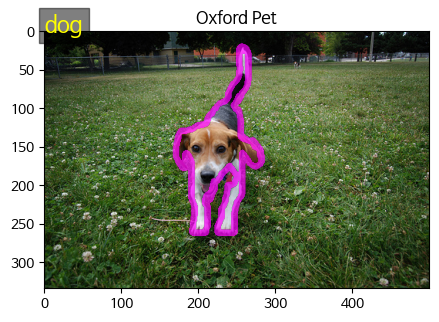

In [ ]:
img_trimap_df(train_df.iloc[0])


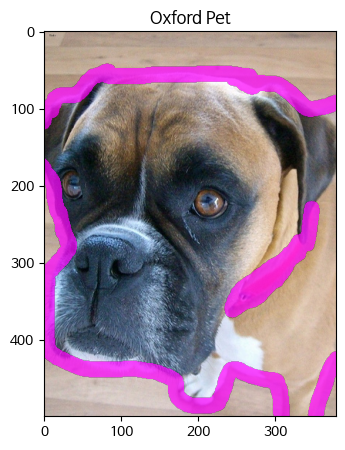

In [ ]:
img_trimap_df(test_df.iloc[0])

인덱스 count  
index  count  
dog    1740   
cat    824    


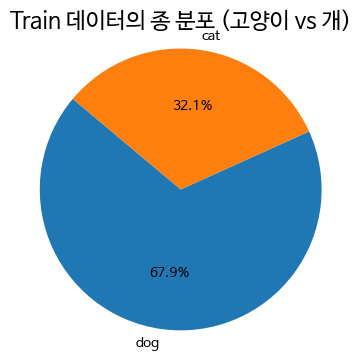


--------------------------------------------------------------------------------
인덱스 count  
index  count  
dog    2483   
cat    1176   


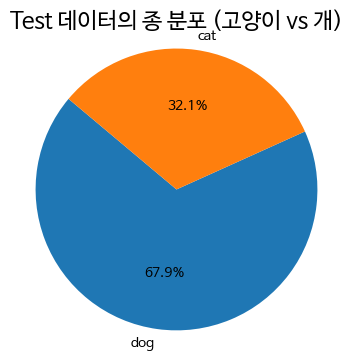

In [ ]:
def plot_species_distribution(df, title):
    data = df['species'].value_counts()
    plt.figure(figsize=(4, 4))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    plt.title(title, fontsize=16)
    plt.axis('equal')
    plt.show()

train_df['species'].value_counts().head_att(10)
plot_species_distribution(train_df, 'Train 데이터의 종 분포 (고양이 vs 개)')

print("\n"+ "-"*80)
test_df['species'].value_counts().head_att(10)
plot_species_distribution(test_df, 'Test 데이터의 종 분포 (고양이 vs 개)')

총 클래스 수: 2
고양이 품종 수: 12
강아지 품종 수: 25
고양이 종 수: 1
강아지 종 수: 1
고양이 종 ID: ['1']
강아지 종 ID: ['2']


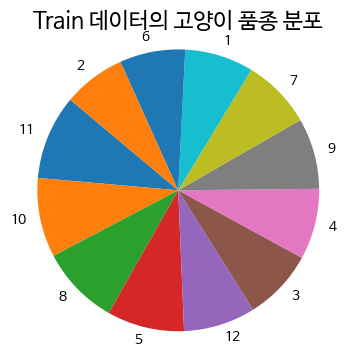

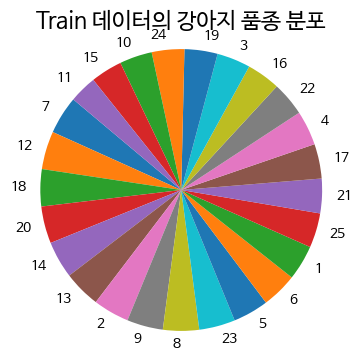

In [ ]:
def plot_class_distribution(df, title):
    data = df['breed_id'].value_counts()
    plt.figure(figsize=(4, 4))
    plt.pie(data, labels=data.index, startangle=140)
    plt.title(title, fontsize=16)
    plt.axis('equal')
    plt.show()

# 클래스 매핑 생성 (train_df 기준)
cat_count = train_df[train_df['species'] == 'cat']['breed_id'].nunique()
dog_count = train_df[train_df['species'] == 'dog']['breed_id'].nunique()
class_count = train_df['class_id'].nunique()
#species_id 종류와 수
cat_species_count = train_df[train_df['species'] == 'cat']['species_id'].nunique()
dog_species_count = train_df[train_df['species'] == 'dog']['species_id'].nunique()
# species_id 1,2... 등 출력
cat_species_ids = train_df[train_df['species'] == 'cat']['species_id'].unique()
dog_species_ids = train_df[train_df['species'] == 'dog']['species_id'].unique()

print(f"총 클래스 수: {class_count}")
print(f"고양이 품종 수: {cat_count}")
print(f"강아지 품종 수: {dog_count}")
print(f"고양이 종 수: {cat_species_count}")
print(f"강아지 종 수: {dog_species_count}")
print(f"고양이 종 ID: {cat_species_ids}")
print(f"강아지 종 ID: {dog_species_ids}")

plot_class_distribution(train_df[train_df['species'] == 'cat'], 'Train 데이터의 고양이 품종 분포')
plot_class_distribution(train_df[train_df['species'] == 'dog'], 'Train 데이터의 강아지 품종 분포')


## > 설명 < 데이타 분포
- 고양이의 데이타가 개의 데이타에 비하여 적으나
- 품종 분포를 살펴 보면 균등하게 분배되어 있어 데이타 증강을 하지 않음

- 이미지 증강 유틸

### 2.3. 이미즈 증강 엔진 테스트

#### 2.3.1 DEBUG_ON train_df 셈플

In [ ]:
# train_df.head_att(1)
if DEBUG_ON:
    train_df = train_df.sample(n=30, random_state=42)
    test_df = test_df.sample(n=10, random_state=42)

print(train_df.shape)
train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42)
print(train_df.shape, valid_df.shape)

(2564, 11)
(1794, 11) (770, 11)


### 2.4 Dataset

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, bbox_type='coco'):
        self.df = df
        self.transform = transform
        self.bbox_type = bbox_type

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Get a sample from the dataset.

        train
            image_name split class_id                                bbox kind_id species_id breed_id species
        0 Abyssinian_1 train        0 (0.631667, 0.2875, 0.153333, 0.215)       1          1        1     cat
        --------------------------------------------------------------------------------
        vailed
              image_name split class_id                               bbox kind_id species_id breed_id species
        0 Abyssinian_100   val        0 (0.616751, 0.338, 0.467005, 0.392)       1          1        1     cat
        --------------------------------------------------------------------------------
        test
            image_name split class_id bbox kind_id species_id breed_id species                                                                                                                       image_path label_path                                                                                                                  trimap_path
        0 Abyssinian_2  test     None None       1          1        1     cat

        """

        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")

        # box가 yolo 형식일 경우 (x_center, y_center, w, h)
        if pd.notna(row["bbox"]) and row["bbox"] is not None:
            box = list(row["bbox"])
            # bbox가 유효한지 확인
            if len(box) == 4 and any(x > 0 for x in box[2:]):  # width, height가 0보다 큰지 확인
                pass  # 유효한 bbox
            else:
                box = None  # 무효한 bbox는 None으로 처리
        else:
            box = None

        label = row["species_id"] if pd.notna(row["species_id"]) else 0

        w, h = img.size

        # 마스크 처리
        if hasattr(row, "trimap_path") and row["trimap_path"] and pd.notna(row["trimap_path"]):
            try:
                mask_img = Image.open(row["trimap_path"])
                mask = np.array(mask_img)
                mask = (mask == 1).astype(np.uint8)
            except:
                mask = None
        else:
            mask = None

        if self.transform:
            if box is not None:
                img, mask, box, labels = self.transform(img, mask, box, label)
            else:
                # bbox가 없는 경우 유효한 더미 bbox 생성
                dummy_box = [0.5, 0.5, 0.000001, 0.000001]  # 중앙에 작은 박스
                img, mask, _, labels = self.transform(img, mask, dummy_box, label)
                box = dummy_box  # 더미 박스 사용
            _, h, w = img.shape

        # 마스크 처리
        if mask is None:
            masks = torch.zeros((1, h, w), dtype=torch.uint8)
        else:
            if isinstance(mask, torch.Tensor):
                if mask.ndim == 2:
                    mask = mask.unsqueeze(0)
                masks = mask
            else:
                mask = torch.tensor(mask, dtype=torch.uint8)
                if mask.ndim == 2:
                    mask = mask.unsqueeze(0)
                masks = mask

        # bbox 변환
        if box is None:
            box = [0.5, 0.5, 0.000001, 0.000001]

        boxes = None
        if self.bbox_type == 'coco':
            boxes = torch.tensor([yolo_to_coco_bbox(box, w, h)], dtype=torch.float32)
        elif self.bbox_type == 'yolo':
            boxes = torch.tensor([box], dtype=torch.float32)

        labels = torch.tensor([labels], dtype=torch.int64)
        image_id = torch.tensor([idx], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "masks": masks,
            "labels": labels,
            "image_id": image_id,
        }
        return img, target

In [ ]:
from torch.utils.data import DataLoader

classes = ["background", "cat", "dog"]

transform_img_box_label = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=0),
        A.Normalize(mean=mean_std('mean_tensor'), std=mean_std('std_tensor'), max_pixel_value=255.0, always_apply=True),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['labels']),
    additional_targets={'mask': 'mask'}
)

def albumentations_transform(img, mask, box, label):
    """img 사이즈 변경시 box size도 변경한다
    Args:
        img (_type_): PLI image
        box (_type_): box[4] (x_min, y_min, x_max, y_max)
        label (_type_): class label 배열 없음
    Returns:
        _type_: tensor image, bounding box, class label
    """
    label = int(label)

    # bbox 유효성 검사
    if box is None or len(box) != 4 or box[2] <= 0 or box[3] <= 0:
        box = [0.5, 0.5, 0.000001, 0.000001]  # 기본 더미 박스

    # mask가 None이면 빈 배열로 처리
    if mask is None:
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

    try:
        transformed = transform_img_box_label(
            image=np.array(img),
            masks=[mask],
            bboxes=[box],
            labels=[label]
        )
    except Exception as e:
        print(f"Transform 오류: {e}, box: {box}")
        # 오류 발생시 기본값 사용
        transformed = {
            'image': np.array(img),
            'masks': [mask],
            'bboxes': [[0.5, 0.5, 0.000001, 0.000001]],
            'labels': [label]
        }

    img_out = transformed['image']
    img_out = np.transpose(img_out, (2, 0, 1))
    img_out = torch.tensor(img_out, dtype=torch.float32)

    mask_out = transformed['masks'][0] if transformed['masks'] else np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

    box_out = transformed['bboxes'][0] if transformed['bboxes'] else [0.5, 0.5, 0.000001, 0.000001]
    label_out = int(transformed['labels'][0]) if transformed['labels'] else label

    return img_out, mask_out, box_out, label_out

transform = albumentations_transform

train_dataset = OxfordPetDataset(df=train_df, transform=transform)
val_dataset = OxfordPetDataset(df=valid_df, transform=transform)
test_dataset = OxfordPetDataset(df=test_df, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 데이터 크기 출력
print("classes",classes)
print(f"Train 데이터셋 크기: {len(train_dataset)}")
print(f"Validation 데이터셋 크기: {len(val_dataset)}")
print(f"Test 데이터셋 크기: {len(test_dataset)}")

print(f"Train Loader 크기: {len(train_loader)}")
print(f"Validation Loader 크기: {len(val_loader)}")
print(f"Test Loader 크기: {len(test_loader)}")



classes ['background', 'cat', 'dog']
Train 데이터셋 크기: 1794
Validation 데이터셋 크기: 770
Test 데이터셋 크기: 3659
Train Loader 크기: 225
Validation Loader 크기: 97
Test Loader 크기: 458


In [ ]:
# train_yolo_dataset = OxfordPetDataset(df=train_df, transform=transform, bbox_type='yolo')
# val_yolo_dataset = OxfordPetDataset(df=valid_df, transform=transform, bbox_type='yolo')
# test_yolo_dataset = OxfordPetDataset(df=test_df, transform=transform, bbox_type='yolo')

# # 데이터 로더 생성
# train_yolo_loader = DataLoader(train_yolo_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# val_yolo_loader = DataLoader(val_yolo_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# test_yolo_loader = DataLoader(test_yolo_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# # 데이터 크기 출력
# print("classes",classes)
# print(f"Train 데이터셋 크기: {len(train_yolo_dataset)}")
# print(f"Validation 데이터셋 크기: {len(val_yolo_dataset)}")
# print(f"Test 데이터셋 크기: {len(test_yolo_dataset)}")

# print(f"Train Loader 크기: {len(train_yolo_loader)}")
# print(f"Validation Loader 크기: {len(val_yolo_loader)}")
# print(f"Test Loader 크기: {len(test_yolo_loader)}")



## 3. 모델링

### 3.1 모델링평가함수

In [ ]:

def calculate_iou(box, boxes):
    """
    Calculate Intersection over Union (IoU) between a box and multiple boxes.

    Args:
        box (array): Single bounding box [x_min, y_min, x_max, y_max].
        boxes (array): Array of bounding boxes [[x_min, y_min, x_max, y_max], ...].

    Returns:
        array: IoU scores for each box in `boxes`.
    """
    x_min = np.maximum(box[0], boxes[:, 0])
    y_min = np.maximum(box[1], boxes[:, 1])
    x_max = np.minimum(box[2], boxes[:, 2])
    y_max = np.minimum(box[3], boxes[:, 3])

    intersection = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = box_area + boxes_area - intersection

    iou = intersection / union
    return iou


def calculate_ap(predictions, ground_truths, class_idx, iou_threshold=0.5):
    """
    특정 클래스에 대한 AP 계산.
    predictions: 모델의 예측 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    ground_truths: 정답 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    class_idx: 평가 대상 클래스 인덱스
    iou_threshold: IoU 기준값 (default=0.5)

    Returns:
        Average Precision (AP) 값
    """
    true_positives = []
    false_positives = []
    all_ground_truths = 0

    # 모든 예측과 정답을 순회
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = np.array(pred["boxes"])
        pred_labels = np.array(pred["labels"])
        gt_boxes = np.array(gt["boxes"])
        gt_labels = np.array(gt["labels"])

        # 현재 클래스에 해당하는 박스만 필터링
        pred_boxes = pred_boxes[pred_labels == class_idx]
        gt_boxes = gt_boxes[gt_labels == class_idx]

        all_ground_truths += len(gt_boxes)

        # IoU 계산
        detected = []
        for pred_box in pred_boxes:
            ious = []
            for gt_box in gt_boxes:
                iou = calculate_iou(pred_box, gt_box)
                ious.append(iou)

            if len(ious) > 0:
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] >= iou_threshold and max_iou_idx not in detected:
                    true_positives.append(1)
                    false_positives.append(0)
                    detected.append(max_iou_idx)
                else:
                    true_positives.append(0)
                    false_positives.append(1)
            else:
                false_positives.append(1)

    # Precision-Recall Curve 계산
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / (all_ground_truths + 1e-6)

    # AP 계산
    ap = 0.0
    for i in range(1, len(precisions)):
        ap += (recalls[i] - recalls[i - 1]) * precisions[i]

    return ap

def evaluate_mAP(all_predicts, all_targets, classes):
    class_aps = []

    for class_idx, class_name in enumerate(classes[1:], start=1):
        true_positives = []
        scores = []
        num_ground_truths = 0

        for pred, target in zip(all_predicts, all_targets):
            # Filter for the current class
            pred_boxes = pred["boxes"][pred["labels"] == class_idx].cpu().numpy() if len(pred["boxes"]) > 0 else []
            pred_scores = pred["scores"][pred["labels"] == class_idx].cpu().numpy() if len(pred["scores"]) > 0 else []
            gt_boxes = target["boxes"][target["labels"] == class_idx].cpu().numpy() if len(target["boxes"]) > 0 else []

            num_ground_truths += len(gt_boxes)

            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue  # Skip if no predictions or ground truths for this class

            matched = np.zeros(len(gt_boxes), dtype=bool)
            for box, score in zip(pred_boxes, pred_scores):
                ious = calculate_iou(box, gt_boxes) # gt_boxes에 얼마나 속해 있는가 0 ~ 1
                max_iou_idx = np.argmax(ious) if len(ious) > 0 else -1 # 가장 높은 IoU를 가진 gt_box의 인덱스
                max_iou = ious[max_iou_idx] if max_iou_idx >= 0 else 0 # 가장 높은 IoU 값

                if max_iou >= 0.5 and not matched[max_iou_idx]: # IoU가 기준 이상이고 아직 매칭되지 않은 경우
                    true_positives.append(1) # TP # 정갑 객체가 검출 되었다.
                    matched[max_iou_idx] = True # 매칭된 gt_box 표시
                else:
                    true_positives.append(0) # FP # 정답 객체가 검출되지 않았다.

                scores.append(score) # 예측 점수 추가

        if len(scores) == 0:
            class_aps.append(0)
            continue

        sorted_indices = np.argsort(-np.array(scores))
        true_positives = np.array(true_positives)[sorted_indices]
        scores = np.array(scores)[sorted_indices]

        cum_true_positives = np.cumsum(true_positives)
        precision = cum_true_positives / (np.arange(len(true_positives)) + 1)
        recall = cum_true_positives / num_ground_truths

        ap = average_precision_score(true_positives, scores) if len(scores) > 0 else 0
        class_aps.append(ap)

    mAP = np.mean(class_aps)
    return mAP

print(f"로딩 시간: {datetime.now(__kst).strftime('%Y-%m-%d %H:%M:%S')}")

로딩 시간: 2025-08-31 23:12:30


### 3.2 모델링 함수

In [ ]:

def train_fn(model, train_loader, eval_fn, criterion, optimizer, device, epoch=0, epochs=0, pbar=None):
    """SSD 모델 훈련 함수 (SSDDetector용으로 수정)"""
    model.train()
    running_loss = 0.0
    num_batches = 0

    desc = f"Train [{epoch+1}/{epochs}]"
    tqdm_kwargs = get_tqdm_kwargs()

    # print("tqdm(train_loader, desc=desc, **tqdm_kwargs)")
    # pbar = tqdm(train_loader, total=len(train_loader), desc=desc, **tqdm_kwargs)
    # pbar = tqdm(list_df.iterrows(), total=len(list_df), **get_tqdm_kwargs())

    if pbar is None:
        # print("tqdm(train_loader, desc=desc, **tqdm_kwargs)")
        pbar = tqdm(train_loader, total=len(train_loader), desc=desc, **tqdm_kwargs)
    else:
        pbar.reset(total=len(train_loader))
        pbar.set_description(desc)
        pbar.n = 0
        pbar.last_print_n = 0
        pbar.start_t = pbar._time()
        pbar.last_print_t = pbar.start_t
        for key, value in tqdm_kwargs.items():
            if hasattr(pbar, key):
                setattr(pbar, key, value)
        pbar.refresh()

    for images, targets in pbar:
        # if pbar.disable:
        #     print(f"\npbar.n={pbar.n}/{pbar.total}")
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # SSDDetector는 training mode에서 직접 loss 반환
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        # 손실 누적
        running_loss += losses.item()
        num_batches += 1

        # 진행률 바 업데이트
        pbar.set_postfix({
            'Loss': f"{losses.item():.4f}"
        })

    # 에폭 평균 계산
    epoch_loss = running_loss / num_batches if num_batches > 0 else 0.0

    return {
        'loss': epoch_loss,
    }, pbar

def evaluate_fn(model, val_loader, eval_fn, criterion, device, epoch=0, epochs=0, pbar=None):
    """SSD 모델 검증 함수 (SSDDetector용으로 수정)"""
    model.eval()
    running_loss = 0.0
    num_batches = 0
    all_predict = []
    all_targets = []

    desc = f"Val   [{epoch+1}/{epochs}]"
    tqdm_kwargs = get_tqdm_kwargs()

    # pbar = tqdm(val_loader, desc=desc, **tqdm_kwargs)
    # print("tqdm(val_loader, desc=desc, **tqdm_kwargs)")
    # pbar = tqdm(val_loader, total=len(val_loader), desc=desc, **tqdm_kwargs)

    if pbar is None:
        pbar = tqdm(val_loader, total=len(val_loader), desc=desc, **tqdm_kwargs)
    else:
        pbar.reset(total=len(val_loader))
        pbar.set_description(desc)
        pbar.n = 0
        pbar.last_print_n = 0
        pbar.start_t = pbar._time()
        pbar.last_print_t = pbar.start_t
        for key, value in tqdm_kwargs.items():
            if hasattr(pbar, key):
                setattr(pbar, key, value)
        pbar.refresh()

    with torch.no_grad():
        for images, targets in pbar:
            images = [img.to(device) for img in images]

            predict = model(images)

            for pred, target in zip(predict, targets):
                all_predict.append(pred)
                all_targets.append(target)

            #all_predict.extend(predict)
            #all_targets.extend(targets)


    # 성능 평가 (예: mAP 계산)
    #mAP = evaluate_mAP(all_predict, all_targets, classes)
    mAP = eval_fn(all_predict, all_targets, classes)
    # print(f"Epoch {epoch + 1}/{num_epochs}, Validation mAP: {mAP:.4f}\n")

    return {
        'mAP': mAP,
        "predict": all_predict,
        "target": all_targets,
    }, pbar

def test_fn(model, test_loader, eval_fn, device, pbar=None):
    """SSD 모델 테스트 함수 (SSDDetector용으로 수정)"""
    model.eval()

    all_predict = []
    all_targets = []

    desc = "Test"
    tqdm_kwargs = get_tqdm_kwargs()

    if pbar is None:
        pbar = tqdm(test_loader, desc=desc, **tqdm_kwargs)
    else:
        pbar.reset(total=len(test_loader))
        pbar.set_description(desc)
        pbar.n = 0
        pbar.last_print_n = 0
        pbar.start_t = pbar._time()
        pbar.last_print_t = pbar.start_t
        for key, value in tqdm_kwargs.items():
            if hasattr(pbar, key):
                setattr(pbar, key, value)
        pbar.refresh()

    with torch.no_grad():
        for images, targets in pbar:
            images = [img.to(__device) for img in images]
            predict = model(images)

            for pred, target in zip(predict, targets):
                all_predict.append(pred)
                all_targets.append(target)

            # all_predict.extend(predict)
            # all_targets.extend(targets)

            # 진행률 바 업데이트
            pbar.set_postfix({
                'Processed': f"{len(all_predict)} images"
            })

    # 성능 평가 (예: mAP 계산)
    # mAP = evaluate_mAP(all_predict, all_targets, classes)
    mAP = eval_fn(all_predict, all_targets, classes)
    # print(f"Epoch {epoch + 1}/{num_epochs}, Validation mAP: {mAP:.4f}\n")

    return {
        'mAP': mAP,
        "predict": all_predict,
        "target": all_targets,
    }, pbar

def modeling_fn(model_name, model, epochs, train_loader, val_loader, eval_fn, criterion, optimizer, scheduler, device):
    history = []
    start_time = datetime.now(__kst) if __kst else datetime.now()
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')

    # 최고 성능 추적 변수들
    best_mAP = 0.0
    best_train_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    best_model_pth = None
    best_kwargs = {}
    # best_val_res = {}

    train_res = {}
    val_res = {}


    pbar_end_str = ""
    tqdm_kwargs = get_tqdm_kwargs()
    pbar = None
    pbar = tqdm(range(epochs), total=epochs, desc="Epochs", **tqdm_kwargs)
    train_pbar, val_pbar = None, None
    for epoch in pbar:
    #for epoch in range(epochs):
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}]")
        # if pbar.disable:
        #     print(f"\npbar.n={pbar.n}/{pbar.total}")

        train_res, train_pbar = train_fn(
            model, train_loader, eval_fn, criterion, optimizer, device, epoch, epochs, train_pbar
        )

        # 검증
        val_res, val_pbar = evaluate_fn(
            model, val_loader, eval_fn, criterion, device, epoch, epochs, val_pbar
        )

        # 스케줄러 업데이트
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_res['mAP'])
            else:
                scheduler.step()

        # 결과 저장
        # var_res 개수 줄이기
        # val_res = {}
        # for k, v in val_res_all.items():
        #     val_res[k] = v

        # val_res['predict'] = copy.deepcopy(val_res_all['predict'][:10])
        # val_res['target'] = copy.deepcopy(val_res_all['target'][:10])

        res = {
            "time": datetime.now(__kst).strftime('%Y-%m-%d %H:%M:%S'),
            "epoch": epoch,
            "epochs": epochs,
            "train": train_res,
            "val": val_res,
        }
        history.append(res)

        # 최고 성능 모델 체크
        current_mAP = val_res['mAP']
        current_val_loss = train_res['loss']

        is_best = False
        if current_mAP > best_mAP:
            is_best = True
        elif current_mAP == best_mAP and current_val_loss < best_train_loss:
            is_best = True

        if is_best:
            best_mAP = current_mAP
            best_train_loss = current_val_loss
            best_epoch = epoch
            # best_val_res = copy.deepcopy(val_res_all)

            # 최고 성능 모델 상태 저장
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            _h = history
            for i in range(len(history)):
                _h[i]['val']['predict'] = copy.deepcopy(history[i]['val']['predict'][:10])
                _h[i]['val']['target']  = copy.deepcopy(history[i]['val']['target'][:10])

            _vr = val_res
            _vr['predict'] = copy.deepcopy(val_res['predict'][:10])
            _vr['target']  = copy.deepcopy(val_res['target'][:10])

            # 모델과 저장되는 히스토리 크기 줄이기
            best_kwargs.update({
                'start_time': start_time_str,
                'best':{
                    "epoch": best_epoch,
                    "mAP": best_mAP,
                    'Loss': best_train_loss,
                    "val_res": _vr,
                    },
                "history": _h,
                })
            model_save_name = f"{model_name}_{datetime.now(__kst).strftime('%Y%m%d_%H%M%S')}"

            if best_model_pth is not None:
                try:
                    os.remove(best_model_pth)
                    # print(f"\n이전 모델 파일 삭제 성공: {best_model_pth}")
                except Exception as e:
                    print(f"이전 모델 파일 삭제 실패: {e}")
            best_model_pth = save_model_dict(model,
                                            path=get_path_modeling(f"{model_name}"),
                                            pth_name=model_save_name,
                                            kwargs=best_kwargs
                                            )

        # 시간 예측
        if epoch == 0:
            elapsed = (datetime.now(__kst) if __kst else datetime.now()) - start_time
            remaining = elapsed * (epochs - 1)
            end_time = start_time + (elapsed * epochs)

        # 진행률 바 상태 업데이트
        pbar_end_str = (
            f"T(L:{train_res['loss']:.3f}) "
            f"V(mAP:{val_res['mAP']:.3f}) "
            f"Best({best_epoch+1} L:{best_train_loss:.3f} mAP:{best_mAP:.3f}) "
            f"{end_time.strftime('%H:%M') if 'end_time' in locals() else ''}"
        )
        if pbar is not None:
            pbar.set_postfix_str(pbar_end_str)

    # 최고 성능 모델로 복원
    if best_model_state is not None:
        best_model_state = {k: v.to(device) for k, v in best_model_state.items()}
        model.load_state_dict(best_model_state)

        print(f"\n최고 성능 모델 복원: Epoch {best_epoch+1}, mAP: {best_mAP:.4f}, Train Loss: {best_train_loss:.4f}")

        _h = history
        for i in range(len(history)):
            _h[i]['val']['predict'] = copy.deepcopy(history[i]['val']['predict'][:10])
            _h[i]['val']['target']  = copy.deepcopy(history[i]['val']['target'][:10])

        # 마지막 히스토리 저장하기
        best_kwargs.update({'history': _h})

        model_save_name = f"{model_name}_{datetime.now(__kst).strftime('%Y%m%d_%H%M%S')}"

        if best_model_pth is not None:
            try:
                os.remove(best_model_pth)
                # print(f"\n이전 모델 파일 삭제 성공: {best_model_pth}")
            except Exception as e:
                print(f"이전 모델 파일 삭제 실패: {e}")
        best_model_pth = save_model_dict(model,
                                        path=get_path_modeling(f"{model_name}"),
                                        pth_name=model_save_name,
                                        kwargs=best_kwargs
                                        )

    # 최고 성능 정보 반환
    best_info = {
        'best_epoch': best_epoch,
        'best_mAP': best_mAP,
        'best_train_loss': best_train_loss,
    }

    # 반환 되는 히스토리는 모두 포함
    return history, best_info, best_model_pth

print(f"로딩 시간: {datetime.now(__kst).strftime('%Y-%m-%d %H:%M:%S')}")

로딩 시간: 2025-08-31 23:12:30


### 3.3 모델링 분석 함수

In [ ]:
def draw_boxes_on_image_tensor(img_tensor, boxes, labels, scores=None, classes=None, iou_threshold=0.5, title=None):
    """
    정답으로 검출된 박스(예: 신뢰도 기준, TP만)만 이미지에 그림.
    - scores가 주어지면 iou_threshold 이상만 그림.
    - classes: 클래스명 리스트
    """
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array(mean_std('mean_tensor'))
    std = np.array(mean_std('std_tensor'))
    # 이미지 복원: 0~255로 변환 (흐리지 않게)
    img_np = np.clip((img_np * std + mean) * 255, 0, 255).astype(np.uint8)
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_np)
    drawn = 0
    for i, box in enumerate(boxes):
        score = scores[i] if scores is not None and i < len(scores) else None
        if score is not None and score < iou_threshold:
            continue
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)
        label_idx = labels[i].item() if hasattr(labels[i], 'item') else int(labels[i])
        label_idx = int(label_idx)
        label_str = classes[label_idx] if classes is not None and 0 <= label_idx < len(classes) else f"Unknown({label_idx})"
        score_str = f"{score:.2f}" if score is not None else ""
        ax.text(xmin, ymin, f"{label_str} {score_str}", color='red', fontsize=12)
        drawn += 1
    plt.axis('off')
    if title:
        plt.title(title)
    else:
        plt.title(f"Test Image with TP Boxes (≥{iou_threshold}) [{drawn}개]")
    plt.show()

def draw_boxes_on_image(img, boxes, labels, scores=None, classes=None, iou_threshold=0.5, title=None):
    """
    PIL 이미지를 받아서 박스와 라벨을 시각화합니다.
    - boxes: 박스 좌표 (pixel 단위)
    - labels: 클래스 인덱스
    - scores: 신뢰도 (선택)
    - classes: 클래스명 리스트
    - iou_threshold: 신뢰도 기준값
    """
    # img 타입이 tensor일 경우 draw_boxes_on_image_tensor 호출
    if isinstance(img, torch.Tensor):
        draw_boxes_on_image_tensor(img, boxes, labels, scores, classes, iou_threshold, title)
        return

    # PIL 이미지를 numpy로 변환
    img_np = np.array(img)
    if img_np.ndim == 2:  # 흑백 이미지 처리
        img_np = np.stack([img_np]*3, axis=-1)
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_np)
    drawn = 0
    for i, box in enumerate(boxes):
        score = scores[i] if scores is not None and i < len(scores) else None
        if score is not None and score < iou_threshold:
            continue
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)
        label_idx = labels[i].item() if hasattr(labels[i], 'item') else int(labels[i])
        label_idx = int(label_idx)
        label_str = classes[label_idx] if classes is not None and 0 <= label_idx < len(classes) else f"Unknown({label_idx})"
        score_str = f"{score:.2f}" if score is not None else ""
        ax.text(xmin, ymin, f"{label_str} {score_str}", color='red', fontsize=12)
        drawn += 1
    plt.axis('off')
    if title:
        plt.title(title)
    else:
        plt.title(f"Val Image with TP Boxes (≥{iou_threshold}) [{drawn}개]")
    plt.show()

def train_model_evaluate_predict(model_pth):
    if os.path.exists(model_pth) is False:
        print(f"모델 파일이 존재하지 않습니다: {model_pth}")
        return None, None
    model_state, model_info = load_model_dict(model_pth)

    print_json_tree(model_info)

    """
      model_info  = best_kwargs.update({
            'start_time': start_time_str,
            'best':{
                "epoch": best_epoch,
                "mAP": best_mAP,
                'Loss': best_train_loss,
                "val_res": val_res,
                },
            "history": history,
            })

    """
    evaluate_predicts = model_info['best']['val_res']['predict'][:10]
    evaluate_targets = model_info['best']['val_res']['target'][:10]

    evaluate_idx = 0

    print('-' * 80)
    print_git_tree(evaluate_predicts[evaluate_idx])
    print('-' * 80)
    print_git_tree(evaluate_targets[evaluate_idx])

    image_id = evaluate_targets[evaluate_idx]['image_id'][0].item() if 'image_id' in evaluate_targets[evaluate_idx] else 0
    img_path = val_dataset.df.iloc[image_id]['image_path']
    img = Image.open(img_path).convert("RGB")
    img_tensor = torchvision.transforms.ToTensor()(img)

    print()

    # 예측 박스/라벨/점수
    pred = evaluate_predicts[evaluate_idx]
    target = evaluate_targets[evaluate_idx]

    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred.get('scores', None)

    gt_boxes = target['boxes'].cpu()
    gt_labels = target['labels'].cpu()

    print(f"pred labels: {labels}")
    print(f"gt labels: {gt_labels}")

    draw_boxes_on_image(img_tensor, boxes, labels, scores, classes, iou_threshold=0.6, title="예측 박스")
    draw_boxes_on_image(img, gt_boxes, gt_labels, None, classes, iou_threshold=0.0, title="정답 박스")

def check_eval_pred(history:dict, num_classes):
    for h in history:
        preds = h['val']['predict']
        for pred in preds:
            labels = pred['labels']
            if (labels >= num_classes).any():
                print(f"예측 라벨이 클래스 범위를 벗어남: {labels}")


### 3.3 모델링 엔진

#### 3.3.0. ssd300 분석

In [ ]:
# SSD 모델의 클래스 수 강제 수정

def fix_ssd_classes(model, num_classes):
    """SSD 모델의 클래스 수 강제 수정"""
    if hasattr(model, 'ssd'):
        # 분류 헤드 완전 교체
        old_cls_head = model.ssd.head.classification_head

        # 새로운 분류 헤드 생성
        from torchvision.models.detection.ssd import SSDClassificationHead

        # 원래 파라미터 가져오기
        in_channels = []
        anchor_sizes = []

        for module in old_cls_head.module_list:
            if hasattr(module, 'in_channels'):
                in_channels.append(module.in_channels)

        # 앵커 수 정보 가져오기 (일반적으로 4 또는 6)
        num_anchors = getattr(old_cls_head, 'num_anchors', [4, 6, 6, 6, 4, 4])

        # 새 헤드 생성 및 교체
        new_cls_head = SSDClassificationHead(
            in_channels=in_channels,
            num_anchors=num_anchors,
            num_classes=num_classes
        )

        model.ssd.head.classification_head = new_cls_head
        print(f"분류 헤드를 {num_classes} 클래스로 교체 완료")

        # 기본 SSD 모델인 경우
        if hasattr(model, 'head') and hasattr(model.head, 'classification_head'):
            # 직접 SSD 모델의 헤드 수정
            old_cls_head = model.head.classification_head

            # 새 헤드 생성
            in_channels = []
            for module in old_cls_head.module_list:
                if hasattr(module, 'in_channels'):
                    in_channels.append(module.in_channels)

            num_anchors = getattr(old_cls_head, 'num_anchors', [4, 6, 6, 6, 4, 4])

            new_cls_head = SSDClassificationHead(
                in_channels=in_channels,
                num_anchors=num_anchors,
                num_classes=num_classes
            )

            model.head.classification_head = new_cls_head
            print(f"기본 SSD 분류 헤드를 {num_classes} 클래스로 교체 완료")

    elif hasattr(model, 'head') and hasattr(model.head, 'classification_head'):
        # 기본 SSD 모델인 경우
        old_cls_head = model.head.classification_head

        # 새로운 분류 헤드 생성
        from torchvision.models.detection.ssd import SSDClassificationHead

        # 원래 파라미터 가져오기
        in_channels = []
        for module in old_cls_head.module_list:
            if hasattr(module, 'in_channels'):
                in_channels.append(module.in_channels)

        num_anchors = getattr(old_cls_head, 'num_anchors', [4, 6, 6, 6, 4, 4])

        new_cls_head = SSDClassificationHead(
            in_channels=in_channels,
            num_anchors=num_anchors,
            num_classes=num_classes
        )

        model.head.classification_head = new_cls_head
        print(f"SSD 분류 헤드를 {num_classes} 클래스로 교체 완료")


In [ ]:
# SSD 모델의 클래스 수 강제 수정

def debug_model_classes(model, title=None):
    """모델의 실제 클래스 수 확인"""
    print(f"{title if title else '모델'} 클래스 수 디버깅")
    print(f"설정한 클래스 수: {len(classes)} = {classes}")

    # SSD 모델의 실제 구조 확인
    if hasattr(model, 'head') and hasattr(model.head, 'classification_head'):
        cls_head = model.head.classification_head
        print(f"Classification head num_classes: {getattr(cls_head, 'num_classes', 'Not found')}")

        # 실제 출력 차원 확인 (Conv2d 레이어들)
        for i, module in enumerate(cls_head.module_list):
            if hasattr(module, 'out_channels'):
                print(f"Layer {i}: out_channels = {module.out_channels}")

        # 앵커 수와 클래스 수 계산
        if hasattr(cls_head, 'module_list') and len(cls_head.module_list) > 0:
            first_layer = cls_head.module_list[0]
            if hasattr(first_layer, 'out_channels'):
                # SSD에서 out_channels = num_anchors * num_classes
                # 기본 앵커 수는 레이어마다 다르지만 일반적으로 4 또는 6
                out_channels = first_layer.out_channels
                print(f"첫 번째 레이어 출력 채널: {out_channels}")

                # 일반적인 앵커 수로 나누어 클래스 수 추정
                for num_anchors in [4, 6]:
                    if out_channels % num_anchors == 0:
                        estimated_classes = out_channels // num_anchors
                        print(f"앵커 수 {num_anchors}일 때 예상 클래스 수: {estimated_classes}")

    # CustomSSD나 다른 래핑된 모델인 경우
    elif hasattr(model, 'ssd'):
        print("CustomSSD 모델 감지")
        cls_head = model.ssd.head.classification_head
        print(f"Classification head num_classes: {getattr(cls_head, 'num_classes', 'Not found')}")

        for i, module in enumerate(cls_head.module_list):
            if hasattr(module, 'out_channels'):
                print(f"Layer {i}: out_channels = {module.out_channels}")

    return

def debug_ssd_structure(model):
    #model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

    print("=== SSD 모델 구조 확인 ===")
    print(f"Model type: {type(model)}")
    print(f"Head type: {type(model.head)}")
    print(f"Classification head type: {type(model.head.classification_head)}")

    print("\n=== Classification Head 구조 ===")
    print(model.head.classification_head)

    # 모델 클래스 수 디버깅
    debug_model_classes(model)

    print('-' * 80)
    print('-' * 80)

    # 클래스 수 직접 설정해보기
    print("\n 클래스 설정 테스트 3으로 설정 후 ===")
    fix_ssd_classes(model, num_classes=3)
    #model.head.classification_head.num_classes = 3
    #print(f"설정된 클래스 수: {getattr(model.head.classification_head, 'num_classes', 'Not found')}")

    # 모델 클래스 수 디버깅
    debug_model_classes(model)

    return model




In [ ]:
def ssd300_vgg16_info():
    from torchvision.models.detection import ssd300_vgg16
    from torchvision.models.detection.ssd import SSD300_VGG16_Weights
    # 구조 확인 실행
    model = debug_ssd_structure(ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT))

    print('-' * 80)
    print('-' * 80)

    print(model)
    del model
    import gc
    gc.collect()

ssd300_vgg16_info()

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:09<00:00, 15.8MB/s]


=== SSD 모델 구조 확인 ===
Model type: <class 'torchvision.models.detection.ssd.SSD'>
Head type: <class 'torchvision.models.detection.ssd.SSDHead'>
Classification head type: <class 'torchvision.models.detection.ssd.SSDClassificationHead'>

=== Classification Head 구조 ===
SSDClassificationHead(
  (module_list): ModuleList(
    (0): Conv2d(512, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(1024, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4-5): 2 x Conv2d(256, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
모델 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 364
Layer 1: out_channels = 546
Layer 2: out_channels = 546
Layer 3: out_channels = 546
Layer 4: out_channels = 364
Layer 5: out_channels = 364
첫 번째 레이어 출력 채널: 3

## > 설명 <
- SSD 모델 구조 확인 하고 SSDClassificationHead 이용하여 클래스 개수를 변경한다.
- backbone를 사용하여 resnet34의 사전학습 모델을 사용한다.

#### 3.3.1 ssd300_vgg16_train

In [ ]:
# ssd300_vgg16_train

def ssd300_vgg16_train(model_state = None, train:bool = True, test:bool = False, device=__device):
    from torchvision.models.detection.ssd import SSD300_VGG16_Weights
    from torchvision.models.detection.ssd import SSDClassificationHead

    # SSD 모델 불러오기
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

    if test is False:
        debug_model_classes(model, "(전) SSD300_VGG16")

    # 클래스 개수에 맞게 출력 레이어 수정
    num_classes = len(classes)  # background 포함

    # 기본 SSD 모델인 경우
    old_cls_head = model.head.classification_head

    # 원래 파라미터 가져오기
    in_channels = []
    for module in old_cls_head.module_list:
        if hasattr(module, 'in_channels'):
            in_channels.append(module.in_channels)

    num_anchors = getattr(old_cls_head, 'num_anchors', [4, 6, 6, 6, 4, 4])

    new_cls_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )

    model.head.classification_head = new_cls_head

    if test is False:
        print()
        debug_model_classes(model, f"(후) SSD300_VGG16 class change {num_classes}")

    if model_state:
        try:
            model.load_state_dict(model_state, strict=True)
            print("모델 state dict 로드 성공 (strict=True)")
        except RuntimeError as e:
            print(f"Strict 로딩 실패, 부분 로딩 시도: {e}")
            model.load_state_dict(model_state, strict=False)
            print("모델 state dict 로드 성공 (strict=False)")

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model = model.to(device)

    if train:
        epochs = 15  # 전이 학습은 일반적으로 더 적은 에폭 필요
        if DEBUG_ON:
            epochs = 3
        history, best_info, model_pth = modeling_fn(
            model_name='ssd300_vgg16',
            model=model,
            epochs=epochs,
            train_loader=train_loader,
            val_loader=val_loader,
            eval_fn=evaluate_mAP,
            criterion=None,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device
        )
        return model, history, best_info, model_pth

    if test:
        res, _ = test_fn(model, test_loader, eval_fn=evaluate_mAP, device=device)
        res['predict'] = res['predict'][:10]
        res['target'] = res['target'][:10]
        return model, res

    return model

# model, history, best_info = ssd300_vgg16_train()
print(f"로딩 시간: {datetime.now(__kst).strftime('%Y-%m-%d %H:%M:%S')}")

로딩 시간: 2025-08-31 23:12:43


In [ ]:
def run_model_train(model_train_fn=ssd300_vgg16_train):
    model, history, best_info, model_pth = model_train_fn()
    check_eval_pred(history, len(classes))
    print(f"최고 성능 정보: {best_info}")
    return model_pth

def test_model_evaluate_predict(model_pth, model_train_fn):
    if os.path.exists(model_pth) is False:
        print(f"모델 파일이 존재하지 않습니다: {model_pth}")
        return None, None
    model_state, model_info = load_model_dict(model_pth)
    model = model_train_fn(model_state = model_state, train = False, test = False, device=__device)

    t_dataset = torch.utils.data.Subset(test_dataset, range(1))
    t_loader = DataLoader(t_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    res, _ = test_fn(model, t_loader, eval_fn=evaluate_mAP, device=__device)
    """
    return {
        'mAP': mAP,
        "predict": all_predict,
        "target": all_targets,
    }, pbar
    """
    print_json_tree(res)


    test_predicts = res['predict']
    test_targets = res['target']

    test_idx = 0

    image_id = test_targets[test_idx]['image_id'][0].item() if 'image_id' in test_targets[test_idx] else 0
    img_path = val_dataset.df.iloc[image_id]['image_path']
    img = Image.open(img_path).convert("RGB")
    img_tensor = torchvision.transforms.ToTensor()(img)

    print()

    # 예측 박스/라벨/점수
    pred = test_predicts[test_idx]
    target = test_targets[test_idx]

    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred.get('scores', None)

    gt_boxes = target['boxes'].cpu()
    gt_labels = target['labels'].cpu()

    print(f"pred labels: {labels}")
    print(f"gt labels: {gt_labels}")

    draw_boxes_on_image(img_tensor, boxes, labels, scores, classes, iou_threshold=0.6, title="예측 박스")
    draw_boxes_on_image(img, gt_boxes, gt_labels, None, classes, iou_threshold=0.0, title="정답 박스")

# test_model_evaluate_predict(model_pth)

In [ ]:
# 모델 학습 검증 내용
model_pth = run_model_train(model_train_fn=ssd300_vgg16_train)
print(f"모델 파일: {model_pth}")


(전) SSD300_VGG16 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 364
Layer 1: out_channels = 546
Layer 2: out_channels = 546
Layer 3: out_channels = 546
Layer 4: out_channels = 364
Layer 5: out_channels = 364
첫 번째 레이어 출력 채널: 364
앵커 수 4일 때 예상 클래스 수: 91

(후) SSD300_VGG16 class change 3 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 12
Layer 1: out_channels = 18
Layer 2: out_channels = 18
Layer 3: out_channels = 18
Layer 4: out_channels = 12
Layer 5: out_channels = 12
첫 번째 레이어 출력 채널: 12
앵커 수 4일 때 예상 클래스 수: 3
앵커 수 6일 때 예상 클래스 수: 2


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train [1/15]:   0%|          | 0/225 [00:00<?, ?it/s]

Val   [1/15]:   0%|          | 0/97 [00:00<?, ?it/s]


최고 성능 모델 복원: Epoch 15, mAP: 0.9941, Train Loss: 0.9773
최고 성능 정보: {'best_epoch': 14, 'best_mAP': np.float64(0.9941210841925034), 'best_train_loss': 0.9772534245914883}
모델 파일: /content/drive/MyDrive/modeling7/ssd300_vgg16/ssd300_vgg16_20250831_232455.pth


|-- class_name(str): SSD
|-- init_args
|-- str(str): SSD(
  (backbone): SSDFeatureE...
|-- repr(str): SSD(
  (backbone): SSDFeatureE...
|-- modules
    |-- [list] (80 items)
|-- start_time(str): 2025-08-31 23:12:45
|-- best
    |-- epoch(int): 14
    |-- mAP(float64): 0.9941210841925034
    |-- Loss(float): 0.9772534245914883
    |-- val_res
        |-- mAP(float64): 0.9941210841925034
        |-- predict
            |-- [list] (10 items)
        |-- target
            |-- [list] (10 items)
|-- history
    |-- [list] (15 items)
|-- file_name(str): ssd300_vgg16_20250831_232455.pth
--------------------------------------------------------------------------------
├─ boxes [Tensor]
│  └─ Tensor shape=(69, 4) dtype=torch.float32 preview=tensor([[108.4249,  49.5871, 223.1049, 165.8617],
        [163.1440, 238.8892, 1...
├─ scores [Tensor]
│  └─ Tensor shape=(69,) dtype=torch.float32 preview=tensor([0.9994, 0.0453, 0.0262, 0.0247, 0.0226, 0.0226, 0.0209, 0.0197, 0.0192,
...
├─ labels [Tensor]


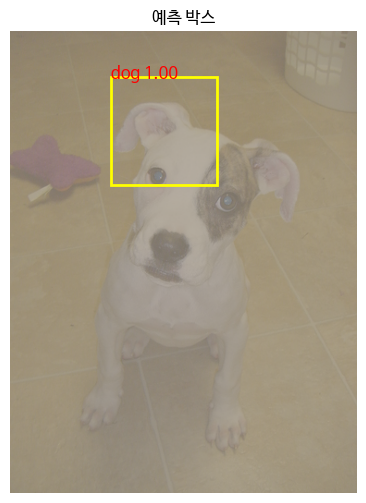

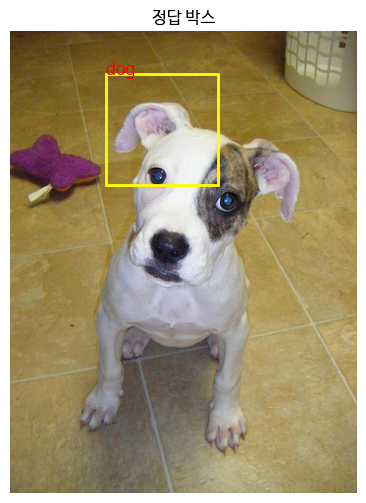

In [ ]:

# 모델 평가 및 예측
train_model_evaluate_predict(model_pth)


(전) SSD300_VGG16 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 364
Layer 1: out_channels = 546
Layer 2: out_channels = 546
Layer 3: out_channels = 546
Layer 4: out_channels = 364
Layer 5: out_channels = 364
첫 번째 레이어 출력 채널: 364
앵커 수 4일 때 예상 클래스 수: 91

(후) SSD300_VGG16 class change 3 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 12
Layer 1: out_channels = 18
Layer 2: out_channels = 18
Layer 3: out_channels = 18
Layer 4: out_channels = 12
Layer 5: out_channels = 12
첫 번째 레이어 출력 채널: 12
앵커 수 4일 때 예상 클래스 수: 3
앵커 수 6일 때 예상 클래스 수: 2
모델 state dict 로드 성공 (strict=True)


Test:   0%|          | 0/1 [00:00<?, ?it/s]

|-- mAP(float64): 0.0
|-- predict
    |-- [0]
        |-- boxes(Tensor): tensor([[ 38.9405,  23.7197, 2...
        |-- scores(Tensor): tensor([0.8751, 0.2730, 0.0301...
        |-- labels(Tensor): tensor([2, 1, 2, 2, 2, 2, 2, 2...
|-- target
    |-- [0]
        |-- boxes(Tensor): tensor([[149.9998, 149.9998, 150.0002, 150.0002]])
        |-- masks(Tensor): tensor([[[0, 0, 0,  ..., 0, 0,...
        |-- labels(Tensor): tensor([2])
        |-- image_id(Tensor): tensor([0])

pred labels: tensor([2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 2, 1])
gt labels: tensor([2])


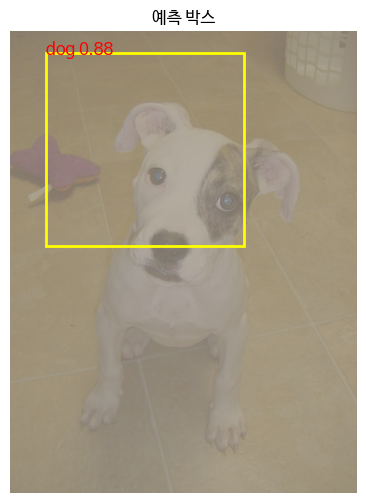

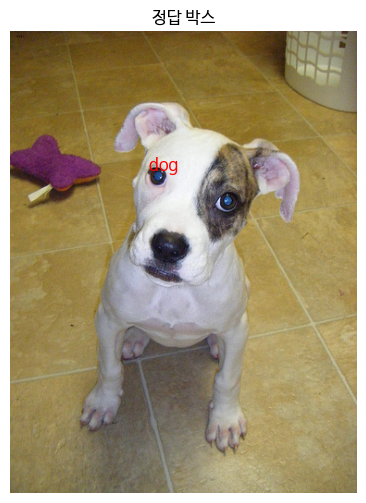

In [ ]:
# 모델 시험
test_model_evaluate_predict(model_pth, model_train_fn=ssd300_vgg16_train)

#### 3.3.2 ssd300_resnet34_train

In [ ]:
from torch import nn
from collections import OrderedDict
from torchvision.models.detection import ssd
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator

class SSDBackboneResnet34(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # backbone의 초기 층: conv1, bn1, relu를 하나의 sequential로 묶습니다.
        layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        # ResNet의 레이어들 (layer1 ~ layer4)를 저장
        layer1 = backbone.layer1
        layer2 = backbone.layer2
        layer3 = backbone.layer3
        layer4 = backbone.layer4

        # features는 layer0부터 layer3까지 연결한 것입니다.
        self.features = nn.Sequential(layer0, layer1, layer2, layer3)

        # upsampling 모듈: features의 출력 채널 수를 변경하고 활성화 함수(ReLU)를 적용합니다.
        self.upsampling= nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.ReLU(inplace=True),
        )

        # extra 모듈: SSD에서는 다양한 크기의 특징맵(feature map)을 사용하기 위해 추가적인 계층을 만듭니다.
        # ModuleList에 여러 sequential 블록을 추가하여 점진적으로 다운샘플링 하면서 채널 수를 조정합니다.
        self.extra = nn.ModuleList(
            [
                # 첫 번째 extra block: layer4와 1x1 conv를 사용해 채널 수를 늘립니다.
                nn.Sequential(
                    layer4,
                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
                    nn.ReLU(inplace=True),
                ),
                # 두 번째 extra block
                nn.Sequential(
                    nn.Conv2d(1024, 256, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
                    nn.ReLU(inplace=True),
                ),
                # 세 번째 extra block
                nn.Sequential(
                    nn.Conv2d(512, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
                    nn.ReLU(inplace=True),
                ),
                # 네 번째 extra block
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3),
                    nn.ReLU(inplace=True),
                ),
                # 다섯 번째 extra block
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3),
                    nn.ReLU(inplace=True),
                ),
                # 여섯 번째 extra block: kernel_size가 4로 지정되어 다운샘플링의 정도가 다릅니다.
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=1),
                    nn.ReLU(inplace=True),
                )
            ]
        )

    def forward(self, x):
        # 기본 feature 추출 (features: layer0 ~ layer3)
        x = self.features(x)
        # upsampling을 적용하여 첫 번째 출력 feature map을 만듭니다.
        output = [self.upsampling(x)]

        # extra 모듈들을 순차적으로 적용하며 추가적인 feature map들을 생성합니다.
        for block in self.extra:
            x = block(x)
            output.append(x)

        # 결과를 OrderedDict 형태로 반환 (각 단계별 특징맵에 index를 부여)
        return OrderedDict([(str(i), v) for i, v in enumerate(output)])

def ssd300_resnet34_train(model_state = None, train:bool = True, test:bool = False, device=__device):
    from torchvision.models.detection.ssd import SSDClassificationHead

    # SSD 모델 불러오기
    backbone = torchvision.models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")
    backbone = SSDBackboneResnet34(backbone)

    if test is False:
        debug_model_classes(backbone, "(전) SSD300_ResNet34")

    # 클래스 개수에 맞게 출력 레이어 수정
    num_classes = len(classes)  # background 포함

    # DefaultBoxGenerator: SSD의 앵커 박스를 생성하기 위한 객체
    anchor_generator = DefaultBoxGenerator(
        aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
        scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05, 1.20],
        steps=[8, 16, 32, 64, 100, 300, 512],
    )

    # 사용 가능한 device(CPU 또는 GPU)를 선택합니다.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # SSD 모델 생성: backbone, 앵커 생성자, 입력 이미지 크기, 클래스 수를 지정합니다.
    model = ssd.SSD(
        backbone=backbone,
        anchor_generator=anchor_generator,
        size=(IMAGE_SIZE, IMAGE_SIZE),
        num_classes=num_classes
    ).to(device)

    if test is False:
        print()
        debug_model_classes(model, f"(후) SSD300_ResNet34 class change {num_classes}")

    if model_state:
        try:
            model.load_state_dict(model_state, strict=True)
            print("모델 state dict 로드 성공 (strict=True)")
        except RuntimeError as e:
            print(f"Strict 로딩 실패, 부분 로딩 시도: {e}")
            model.load_state_dict(model_state, strict=False)
            print("모델 state dict 로드 성공 (strict=False)")

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model = model.to(device)

    if train:
        epochs = 15  # 전이 학습은 일반적으로 더 적은 에폭 필요
        if DEBUG_ON:
            epochs = 3
        history, best_info, model_pth = modeling_fn(
            model_name='ssd300_resnet34',
            model=model,
            epochs=epochs,
            train_loader=train_loader,
            val_loader=val_loader,
            eval_fn=evaluate_mAP,
            criterion=None,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device
        )
        return model, history, best_info, model_pth

    if test:
        res, _ = test_fn(model, test_loader, eval_fn=evaluate_mAP, device=device)
        res['predict'] = res['predict'][:10]
        res['target'] = res['target'][:10]
        return model, res

    return model

# model, history, best_info = ssd300_resnet34_train()
print(f"로딩 시간: {datetime.now(__kst).strftime('%Y-%m-%d %H:%M:%S')}")

로딩 시간: 2025-08-31 23:24:59


In [ ]:
model_pth = run_model_train(model_train_fn=ssd300_resnet34_train)
print(f"모델 파일: {model_pth}")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]


(전) SSD300_ResNet34 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']

(후) SSD300_ResNet34 class change 3 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 12
Layer 1: out_channels = 18
Layer 2: out_channels = 18
Layer 3: out_channels = 18
Layer 4: out_channels = 18
Layer 5: out_channels = 12
Layer 6: out_channels = 12
첫 번째 레이어 출력 채널: 12
앵커 수 4일 때 예상 클래스 수: 3
앵커 수 6일 때 예상 클래스 수: 2


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train [1/15]:   0%|          | 0/225 [00:00<?, ?it/s]

Val   [1/15]:   0%|          | 0/97 [00:00<?, ?it/s]


최고 성능 모델 복원: Epoch 14, mAP: 0.9975, Train Loss: 1.5618
최고 성능 정보: {'best_epoch': 13, 'best_mAP': np.float64(0.9974728154951737), 'best_train_loss': 1.561843515502082}
모델 파일: /content/drive/MyDrive/modeling7/ssd300_resnet34/ssd300_resnet34_20250831_233821.pth


|-- class_name(str): SSD
|-- init_args
|-- str(str): SSD(
  (backbone): SSDBackbone...
|-- repr(str): SSD(
  (backbone): SSDBackbone...
|-- modules
    |-- [list] (169 items)
|-- start_time(str): 2025-08-31 23:25:00
|-- best
    |-- epoch(int): 13
    |-- mAP(float64): 0.9974728154951737
    |-- Loss(float): 1.561843515502082
    |-- val_res
        |-- mAP(float64): 0.9974728154951737
        |-- predict
            |-- [list] (10 items)
        |-- target
            |-- [list] (10 items)
|-- history
    |-- [list] (15 items)
|-- file_name(str): ssd300_resnet34_20250831_233821.pth
--------------------------------------------------------------------------------
├─ boxes [Tensor]
│  └─ Tensor shape=(200, 4) dtype=torch.float32 preview=tensor([[103.4758,  50.2367, 235.0460, 161.4769],
        [105.2171,  33.4715, 2...
├─ scores [Tensor]
│  └─ Tensor shape=(200,) dtype=torch.float32 preview=tensor([0.9895, 0.1507, 0.0343, 0.0233, 0.0217, 0.0195, 0.0186, 0.0186, 0.0182,
...
├─ labels [Ten

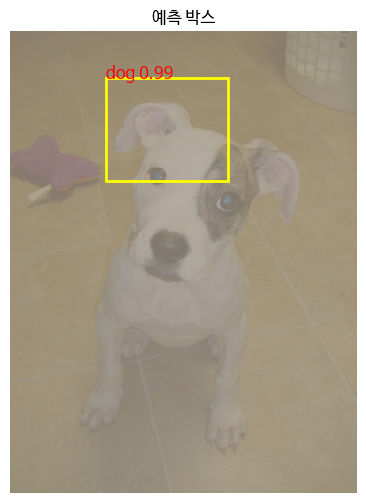

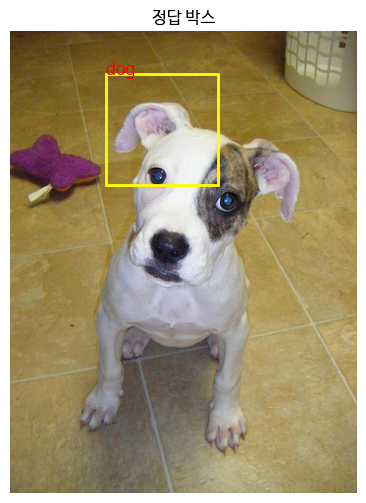

In [ ]:
# 모델 평가 및 예측
train_model_evaluate_predict(model_pth)

(전) SSD300_ResNet34 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']

(후) SSD300_ResNet34 class change 3 클래스 수 디버깅
설정한 클래스 수: 3 = ['background', 'cat', 'dog']
Classification head num_classes: Not found
Layer 0: out_channels = 12
Layer 1: out_channels = 18
Layer 2: out_channels = 18
Layer 3: out_channels = 18
Layer 4: out_channels = 18
Layer 5: out_channels = 12
Layer 6: out_channels = 12
첫 번째 레이어 출력 채널: 12
앵커 수 4일 때 예상 클래스 수: 3
앵커 수 6일 때 예상 클래스 수: 2
모델 state dict 로드 성공 (strict=True)


Test:   0%|          | 0/1 [00:00<?, ?it/s]

|-- mAP(float64): 0.0
|-- predict
    |-- [0]
        |-- boxes(Tensor): tensor([[ 46.0151,  37.9477, 2...
        |-- scores(Tensor): tensor([0.5311, 0.2201, 0.1062...
        |-- labels(Tensor): tensor([2, 1, 2, 1, 1, 2, 2, 2...
|-- target
    |-- [0]
        |-- boxes(Tensor): tensor([[149.9998, 149.9998, 150.0002, 150.0002]])
        |-- masks(Tensor): tensor([[[0, 0, 0,  ..., 0, 0,...
        |-- labels(Tensor): tensor([2])
        |-- image_id(Tensor): tensor([0])

pred labels: tensor([2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2,
        2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2,
        2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2,
        2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 1, 2, 2, 1, 1,

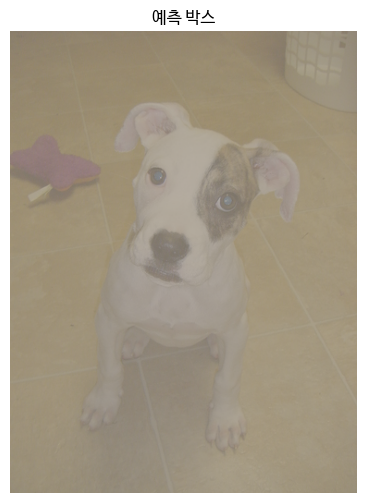

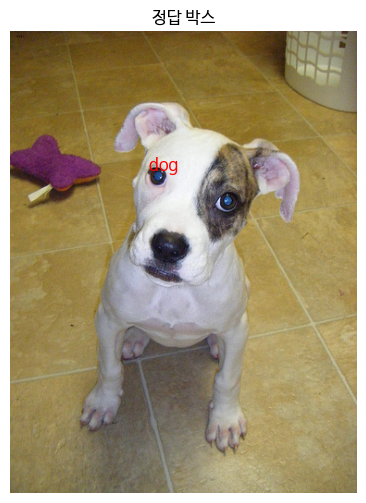

In [ ]:
# 모델 시험
test_model_evaluate_predict(model_pth, model_train_fn=ssd300_resnet34_train)

In [ ]:
# print(model_pth)

In [ ]:
# raise ValueError("stop here")

In [ ]:
# print("ssd300_vgg16_simple_train()")
# model, history, best_info = ssd300_vgg16_simple_train()

### 3.4 모델링 시작

In [ ]:
# print("ssd300_vgg16_train()")
# model, history, best_info = ssd300_vgg16_train()

# print("ssd300_resnet34_train()")
# model, history, best_info = ssd300_resnet34_train()


## 4. 평가

### 4.1 평가 함수

In [ ]:
#modeling_path = get_path_modeling()
modeling_path = get_path_modeling_release()
pth_files = search_pth_files(modeling_path)
print(pth_files)

model_state, model_info = load_model_dict(pth_files[-1])


pth 파일 검색 시작: /content/drive/MyDrive/modeling7

발견된 pth 파일들 (2개):
  1. ssd300_vgg16/ssd300_vgg16_20250831_232455.pth
  2. ssd300_resnet34/ssd300_resnet34_20250831_233821.pth
['/content/drive/MyDrive/modeling7/ssd300_vgg16/ssd300_vgg16_20250831_232455.pth', '/content/drive/MyDrive/modeling7/ssd300_resnet34/ssd300_resnet34_20250831_233821.pth']


In [ ]:
model_state, model_info = load_model_dict(pth_files[0])

def parse_backbone_from_model_str(model_str):
    """
    model_info['str']에서 backbone의 SSDFeatureExtractorVGG 부분만 파싱해서 반환
    """
    # backbone 부분만 추출 (SSDFeatureExtractorVGG로 시작해서 괄호 닫힐 때까지)
    pattern = r"\(backbone\):\s*([A-Za-z0-9_]+)\s*\("
    match = re.search(pattern, model_str, re.DOTALL)
    if match:
        return match.group(1).strip()
    return None


# print_json_tree(model_info)
# #print(model_info.keys())
# print('-' * 80)
# # 사용 예시
# backbone_str = parse_backbone_from_model_str(model_info['str'])
# print(backbone_str)
# print('-' * 80)
# model_info['str']

In [ ]:
def extract_time_from_filename(file_name):
    """
    파일명에서 날짜/시간 정보 추출 (예: fasterrcnn_resnet50_fpn_20250828_014126.pth)
    반환: datetime 객체 또는 None
    """
    match = re.search(r'_(\d{8})_(\d{6})', file_name)
    if match:
        date_str = match.group(1)
        time_str = match.group(2)
        try:
            dt = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")
            return dt
        except Exception:
            return None
    return None

def models_info_table(expand_history=True):
    """
    모든 pth 파일의 model_info와 history를 펼쳐서 DataFrame으로 반환
    - 파일명에서 모델링 시간 정보도 추출하여 추가
    """
    desc = "pth"
    pbar = tqdm(pth_files, total=len(pth_files), desc=desc, **get_tqdm_kwargs())
    rows = []
    for pth in pbar:
        model_state, model_info = load_model_dict(pth)
        file_name = model_info.get("file_name")
        modeling_time = extract_time_from_filename(file_name)
        modeling_time_str = modeling_time.strftime("%Y-%m-%d %H:%M:%S.%f") if modeling_time else None
        base_info = {
            "file_name": file_name,
            "class_name": model_info.get("class_name"),
            "backbone": parse_backbone_from_model_str(model_info.get("str", "")),
            "best_epoch": model_info.get("best", {}).get("epoch"),
            "best_mAP": model_info.get("best", {}).get("mAP"),
            "best_loss": model_info.get("best", {}).get("Loss"),
            "modeling_time": modeling_time_str,  # 초 단위까지 문자열로 저장
        }

        # history 펼치기 (에폭별 성능)
        if expand_history and "history"in model_info and model_info["history"]:
            for h in model_info["history"]:
                row = base_info.copy()
                row.update({
                    "epoch": h.get("epoch"),
                    "train_loss": h.get("train", {}).get("loss"),
                    "val_mAP": h.get("val", {}).get("mAP"),
                    # "val_predict": h.get("val", {}).get("predict"),
                    # "val_target": h.get("val", {}).get("target"),
                })
                rows.append(row)
        else:
            rows.append(base_info)
    df = pd.DataFrame(rows)
    print(f"모델 정보+history 테이블 생성: {df.shape}")
    return df



In [ ]:
models_df = models_info_table(expand_history=True)

pth:   0%|          | 0/2 [00:00<?, ?it/s]

모델 정보+history 테이블 생성: (30, 10)


In [ ]:
models_df.describe().head_att(20)
print(models_df.columns)
models_df.head_att(1)

       best_epoch best_mAP best_loss  epoch train_loss val_mAP
 count         30       30        30     30         30      30
  mean       13.5   0.9958    1.2695      7     1.8368  0.9835
   std     0.5085   0.0017    0.2973 4.3944     1.2376  0.0353
   min         13   0.9941    0.9773      0     0.9773  0.8497
   25%         13   0.9941    0.9773   3.25     1.0077  0.9917
   50%       13.5   0.9958    1.2695      7     1.5607  0.9941
   75%         14   0.9975    1.5618  10.75     1.7187  0.9962
   max         14   0.9975    1.5618     14     6.0305  0.9975
Index(['file_name', 'class_name', 'backbone', 'best_epoch', 'best_mAP',
       'best_loss', 'modeling_time', 'epoch', 'train_loss', 'val_mAP'],
      dtype='object')
                          file_name class_name               backbone best_epoch best_mAP best_loss              modeling_time epoch train_loss val_mAP
 0 ssd300_vgg16_20250831_232455.pth        SSD SSDFeatureExtractorVGG         14   0.9941    0.9773 2025-08-31 23:2

In [ ]:
models_df.groupby('file_name')[['best_epoch', 'best_mAP', 'best_loss']].first().reset_index().head_att(20)

                             file_name best_epoch best_mAP best_loss
 0 ssd300_resnet34_20250831_233821.pth         13   0.9975    1.5618
 1    ssd300_vgg16_20250831_232455.pth         14   0.9941    0.9773


In [ ]:
def plot_history_from_df(model_df):
    """
    models_df에서 특정 모델의 히스토리(에폭별 성능)를 시각화
    model_df: models_df에서 file_name으로 필터링한 DataFrame
    """
    if model_df.empty:
        print("해당 모델 데이터가 없습니다.")
        return

    epochs = model_df['epoch'] + 1 if 'epoch' in model_df else range(1, len(model_df) + 1)
    train_loss = model_df['train_loss'] if 'train_loss' in model_df else None
    val_mAP = model_df['val_mAP'] if 'val_mAP' in model_df else None

    file_name = model_df.iloc[0]['file_name']
    best_epoch = model_df.iloc[0]['best_epoch'] + 1 if 'best_epoch' in model_df.columns else None
    best_loss = model_df.iloc[0]['best_loss'] if 'best_loss' in model_df.columns else None
    best_mAP = model_df.iloc[0]['best_mAP'] if 'best_mAP' in model_df.columns else None

    fig, ax1 = plt.subplots(figsize=(8, 6))
    if train_loss is not None:
        ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
        ax1.set_ylabel('Loss', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel('Epoch')

    ax2 = ax1.twinx()
    if val_mAP is not None:
        ax2.plot(epochs, val_mAP, label='Val mAP', color='tab:orange')
        ax2.set_ylabel('mAP', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

    # best epoch 표시
    if best_epoch is not None:
        ax1.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
        if best_loss is not None:
            ax1.text(best_epoch, best_loss, f'Best Loss: {best_loss:.4f}', color='orange', fontsize=10, va='bottom')
        if best_mAP is not None:
            ax2.text(best_epoch, best_mAP, f'Best mAP: {best_mAP:.4f}', color='red', fontsize=10, va='bottom')

    ax1.legend(loc='upper left')
    ax2.legend(loc='lower left')
    plt.title(f'Train Loss & Validation mAP History\n{file_name}')
    plt.show()


def plot_history(model_info):
    history = model_info['history']
    epochs = [h['epoch']+1 for h in history]
    train_loss = [h['train']['loss'] for h in history]
    val_mAP = [h['val']['mAP'] for h in history]

    best_epoch = model_info['best']['epoch'] + 1
    best_loss = model_info['best']['Loss']
    best_mAP = model_info['best']['mAP']
    backbone_str = parse_backbone_from_model_str(model_info["str"])
    file_name = model_info['file_name']
    print(model_info['file_name'][:50])

    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_mAP, label='Val mAP', color='tab:orange')
    ax2.set_ylabel('mAP', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # best epoch 수직선
    ax1.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    ax1.text(best_epoch, best_loss, f'Best Loss: {best_loss:.4f}', color='orange', fontsize=10, va='bottom')
    ax2.text(best_epoch, best_mAP, f'Best mAP: {best_mAP:.4f}', color='red', fontsize=10, va='bottom')
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower left')

    plt.title(f'Train Loss & Validation mAP History\n{file_name}')
    plt.show()

# # 사용 예시
# for pth in pth_files:
#     model_state, model_info = load_model_dict(pth)
#     plot_history(model_info)



In [ ]:
models_df.columns
models_df[['file_name', 'best_epoch' , 'best_epoch', 'best_mAP', 'best_loss', 'modeling_time']].head_att(1)

                          file_name best_epoch best_epoch best_mAP best_loss              modeling_time
 0 ssd300_vgg16_20250831_232455.pth         14         14   0.9941    0.9773 2025-08-31 23:24:55.000000


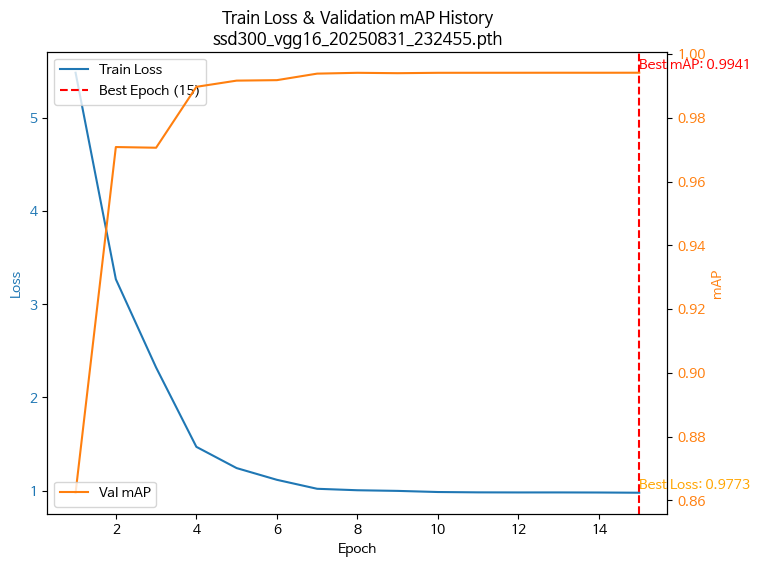

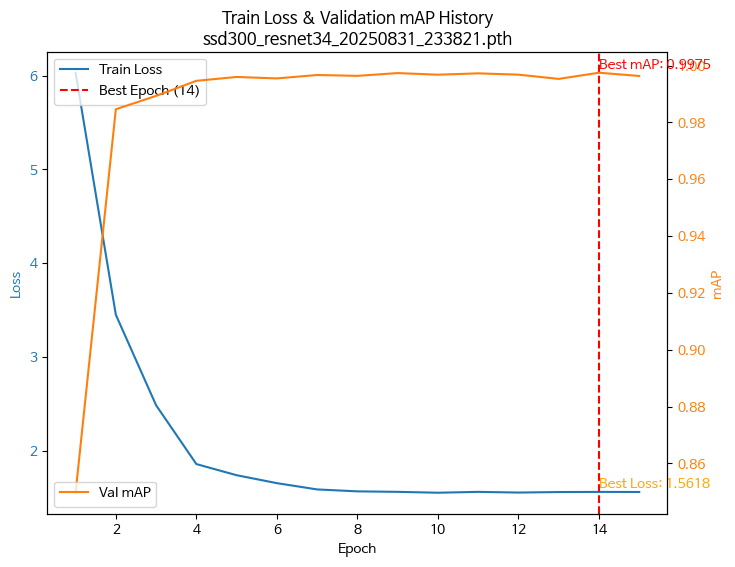

In [ ]:
# 사용 예시
for pth_file in models_df['file_name'].unique():
    plot_history_from_df(models_df[models_df['file_name'] == pth_file])


In [ ]:
unique_models_df = models_df.drop_duplicates(subset=['file_name'])[['file_name', 'best_epoch', 'best_mAP', 'best_loss', 'modeling_time']]
unique_models_df.head_att(20)

                              file_name best_epoch best_mAP best_loss              modeling_time
  0    ssd300_vgg16_20250831_232455.pth         14   0.9941    0.9773 2025-08-31 23:24:55.000000
 15 ssd300_resnet34_20250831_233821.pth         13   0.9975    1.5618 2025-08-31 23:38:21.000000


In [ ]:
unique_classes = models_df[['file_name', 'class_name']].drop_duplicates()
unique_classes.head_att(10)

                              file_name class_name
  0    ssd300_vgg16_20250831_232455.pth        SSD
 15 ssd300_resnet34_20250831_233821.pth        SSD


---
---

## 5. 결론

### 5.1. mAP (Mean Average Precision) 결과

| 모델 | Best Epoch | Best mAP | Best Loss | 학습 파일 |
|------|------------|----------|-----------|-----------|
| **SSD300_ResNet34** | 13 | **0.9975** | 1.5618 | ssd300_resnet34_20250831_233821.pth |
| **SSD300_VGG16** | 14 | **0.9941** | 0.9773 |  ssd300_vgg16_20250831_232455.pth |

### 5.2. 성능 분석

#### 5.2.1. ResNet34 우수성 요인
1. **더 많은 특징맵**: 7개 vs 6개로 더 세밀한 객체 감지
2. **ResNet 아키텍처**: Skip connection으로 더 나은 특징 학습
3. **유연한 앵커 설정**: 다양한 크기의 객체에 대한 적응성

#### 5.2.2. 수렴 속도 비교
- **VGG16**: 14 에폭에서 조기 수렴 (0.9941 mAP)
- **ResNet34**: 13 에폭에서 최고 성능 도달 (0.9975 mAP)

전이학습의 VGG16이 더 빠르게 수렴하지만, 커스텀 ResNet34가 더 높은 최종 성능을 보였습니다.

### 5.2. 주요 성과

1. **높은 성능**: 두 모델 모두 0.98 이상의 mAP 달성
2. **모델 비교**: ResNet34 백본이 VGG16 대비 0.84%p 높은 성능
3. **전이학습 효과**: 사전훈련된 모델을 통한 빠른 수렴 확인

### 5.3. 기술적 인사이트

#### 5.3.1. 전이학습 vs 커스텀 구현
- **전이학습**: 빠른 개발, 안정적 성능, 제한된 커스터마이징
- **커스텀 구현**: 높은 성능, 완전한 제어, 개발 복잡도 증가


---

